In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import networkx as nx
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
colors = sns.color_palette("viridis", 10)

print("Loading and preparing NYC Mobility Survey Trip 2019 dataset...")

# Load the dataset
file_path = "/Users/james_kj_huang/Downloads/664_Citywide_Mobility_Survey_Trip_2019.csv"
trips_df = pd.read_csv(file_path)

print(f"Dataset loaded with {len(trips_df)} records and {len(trips_df.columns)} variables.")

# Basic data cleaning and preparation
def clean_data(df):
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['trip_duration', 'trip_distance']
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Create multi-modal indicator
    if all(col in df_clean.columns for col in ['mode_1', 'mode_2']):
        df_clean['is_multimodal'] = df_clean['mode_2'].notna()
    
    # Clean zone names if needed
    for col in ['o_cms_zone', 'd_cms_zone', 'home_cms_zone']:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Unknown')
    
    # Create derived variables for analysis
    
    # Day type (weekday/weekend)
    if 'travel_date_dow' in df_clean.columns:
        df_clean['is_weekend'] = df_clean['travel_date_dow'].isin([6, 7])  # Assuming 6,7 are weekend
        df_clean['day_type'] = df_clean['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
    
    # Trip purpose categories
    purpose_map = {
        1: 'Home',
        2: 'Work',
        3: 'School',
        4: 'Shopping',
        5: 'Personal Business',
        6: 'Social/Recreation',
        7: 'Medical',
        8: 'Transport Someone',
        9: 'Meal',
        10: 'Religious',
        11: 'Other'
    }
    
    if 'o_purpose_category' in df_clean.columns:
        df_clean['origin_purpose'] = df_clean['o_purpose_category'].map(purpose_map)
    
    if 'd_purpose_category' in df_clean.columns:
        df_clean['destination_purpose'] = df_clean['d_purpose_category'].map(purpose_map)
    
    # Mode type mapping (adjust based on actual coding in your dataset)
    mode_map = {
        1: 'Walk',
        2: 'Bike',
        3: 'Car (driver)',
        4: 'Car (passenger)',
        5: 'Taxi/Uber/Lyft',
        6: 'Subway',
        7: 'Bus',
        8: 'Ferry',
        9: 'Commuter Rail',
        10: 'Other'
    }
    
    if 'mode_type' in df_clean.columns:
        df_clean['mode_category'] = df_clean['mode_type'].map(mode_map)
    
    # Group modes into broader categories
    if 'mode_category' in df_clean.columns:
        df_clean['mode_group'] = df_clean['mode_category'].apply(
            lambda x: 'Active Transport' if x in ['Walk', 'Bike'] else
                     ('Public Transit' if x in ['Subway', 'Bus', 'Ferry', 'Commuter Rail'] else
                     ('Car/Taxi' if x in ['Car (driver)', 'Car (passenger)', 'Taxi/Uber/Lyft'] else 'Other'))
        )
    
    print("Data cleaning complete.")
    return df_clean

# Clean the data
clean_trips = clean_data(trips_df)

print("\nExploring basic dataset characteristics...")
print(f"Date range: {clean_trips['travel_date'].min()} to {clean_trips['travel_date'].max()}")
print(f"Number of unique origin zones: {clean_trips['o_cms_zone'].nunique()}")
print(f"Number of unique destination zones: {clean_trips['d_cms_zone'].nunique()}")

if 'mode_category' in clean_trips.columns:
    print("\nMode distribution:")
    mode_counts = clean_trips['mode_category'].value_counts()
    for mode, count in mode_counts.items():
        print(f"  {mode}: {count} trips ({count/len(clean_trips)*100:.1f}%)")

# Save memory by dropping the original dataframe if it's large
del trips_df

# Create output directory for visualizations
import os
os.makedirs('nyc_transit_analysis', exist_ok=True)

print("\n--- Beginning Analysis for Core Narrative Themes ---")

Loading and preparing NYC Mobility Survey Trip 2019 dataset...
Dataset loaded with 85459 records and 77 variables.
Data cleaning complete.

Exploring basic dataset characteristics...
Date range: 05/22/2019 to 06/30/2019
Number of unique origin zones: 13
Number of unique destination zones: 13

Mode distribution:
  Commuter Rail: 31060 trips (36.3%)
  Bus: 23678 trips (27.7%)
  Subway: 13263 trips (15.5%)
  Car (passenger): 5355 trips (6.3%)
  Other: 1379 trips (1.6%)
  Ferry: 1342 trips (1.6%)
  Bike: 1244 trips (1.5%)
  Walk: 696 trips (0.8%)
  Car (driver): 662 trips (0.8%)
  Taxi/Uber/Lyft: 441 trips (0.5%)

--- Beginning Analysis for Core Narrative Themes ---



Theme 1: Analyzing spatial patterns in NYC transportation...


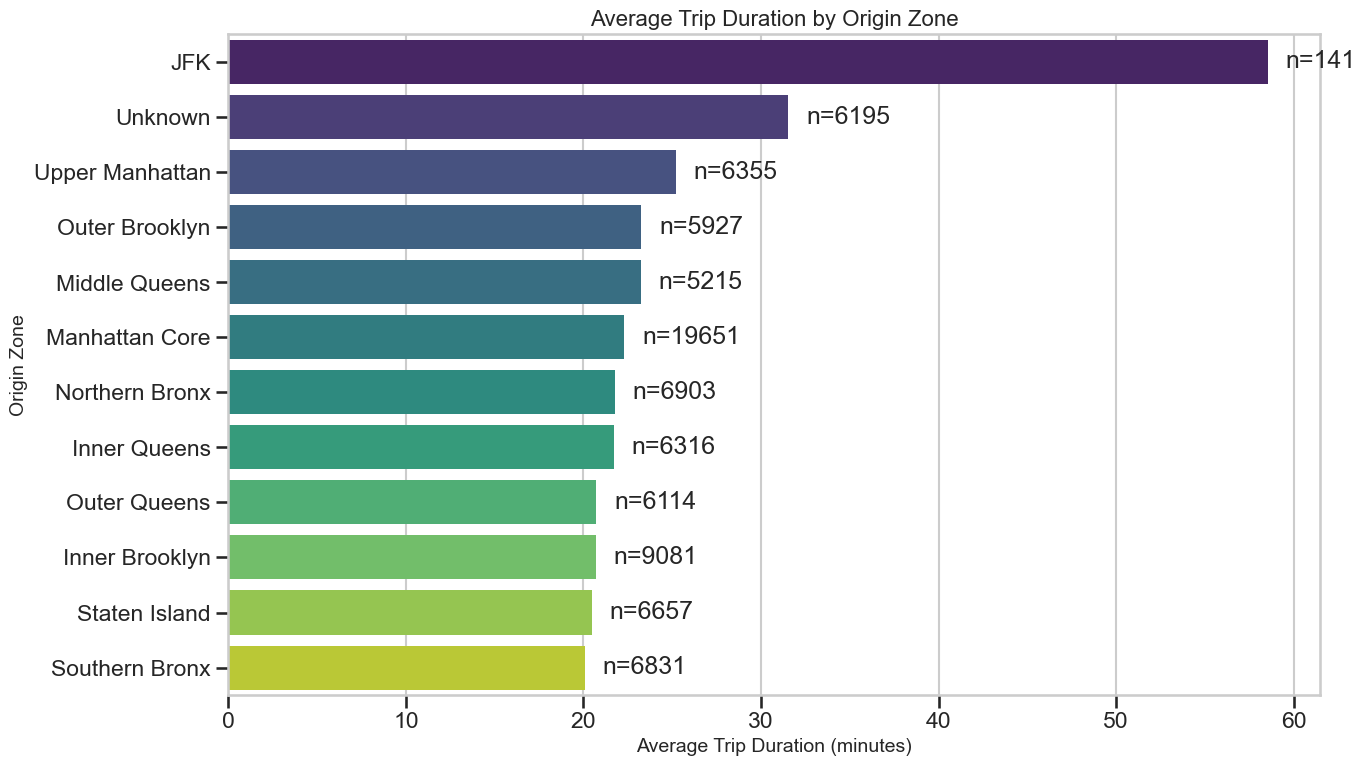

  Analysis 1.1: Trip duration by origin zone - Complete


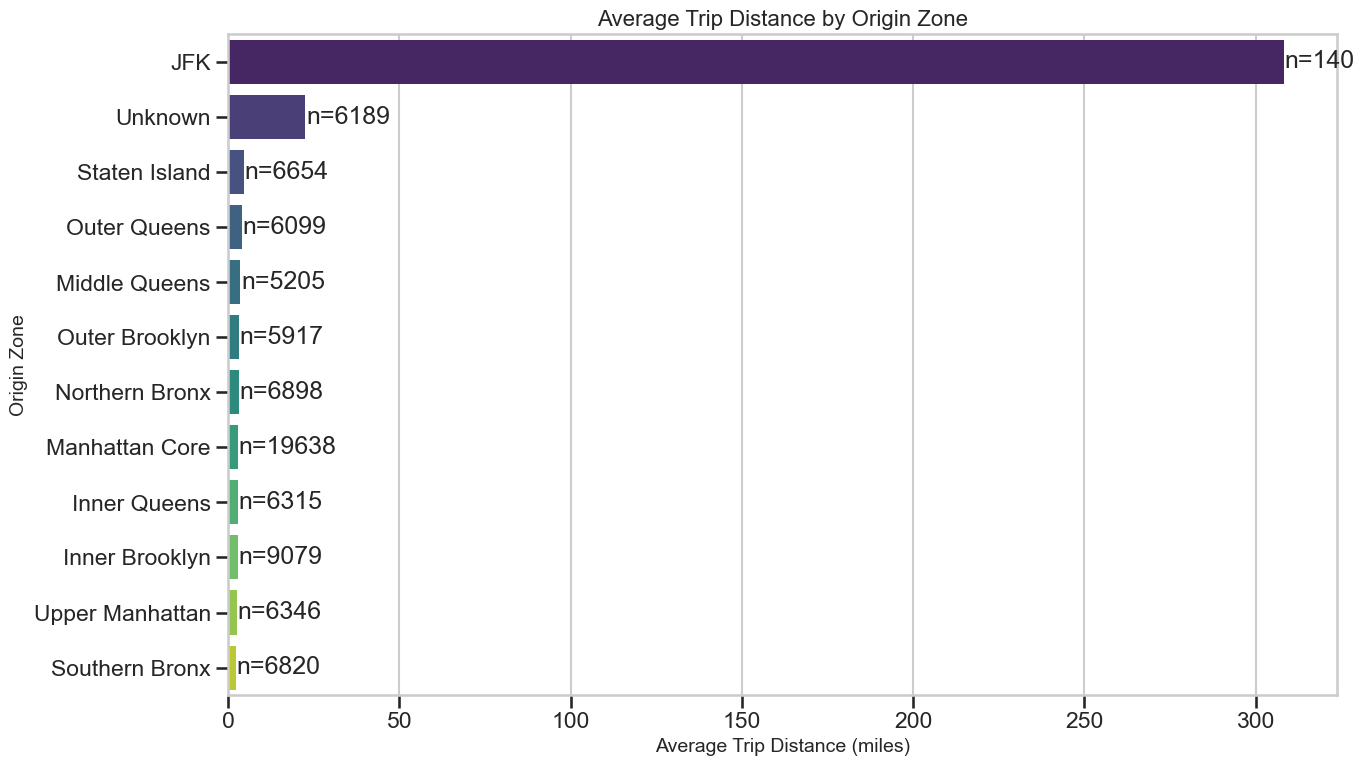

  Analysis 1.2: Trip distance by origin zone - Complete


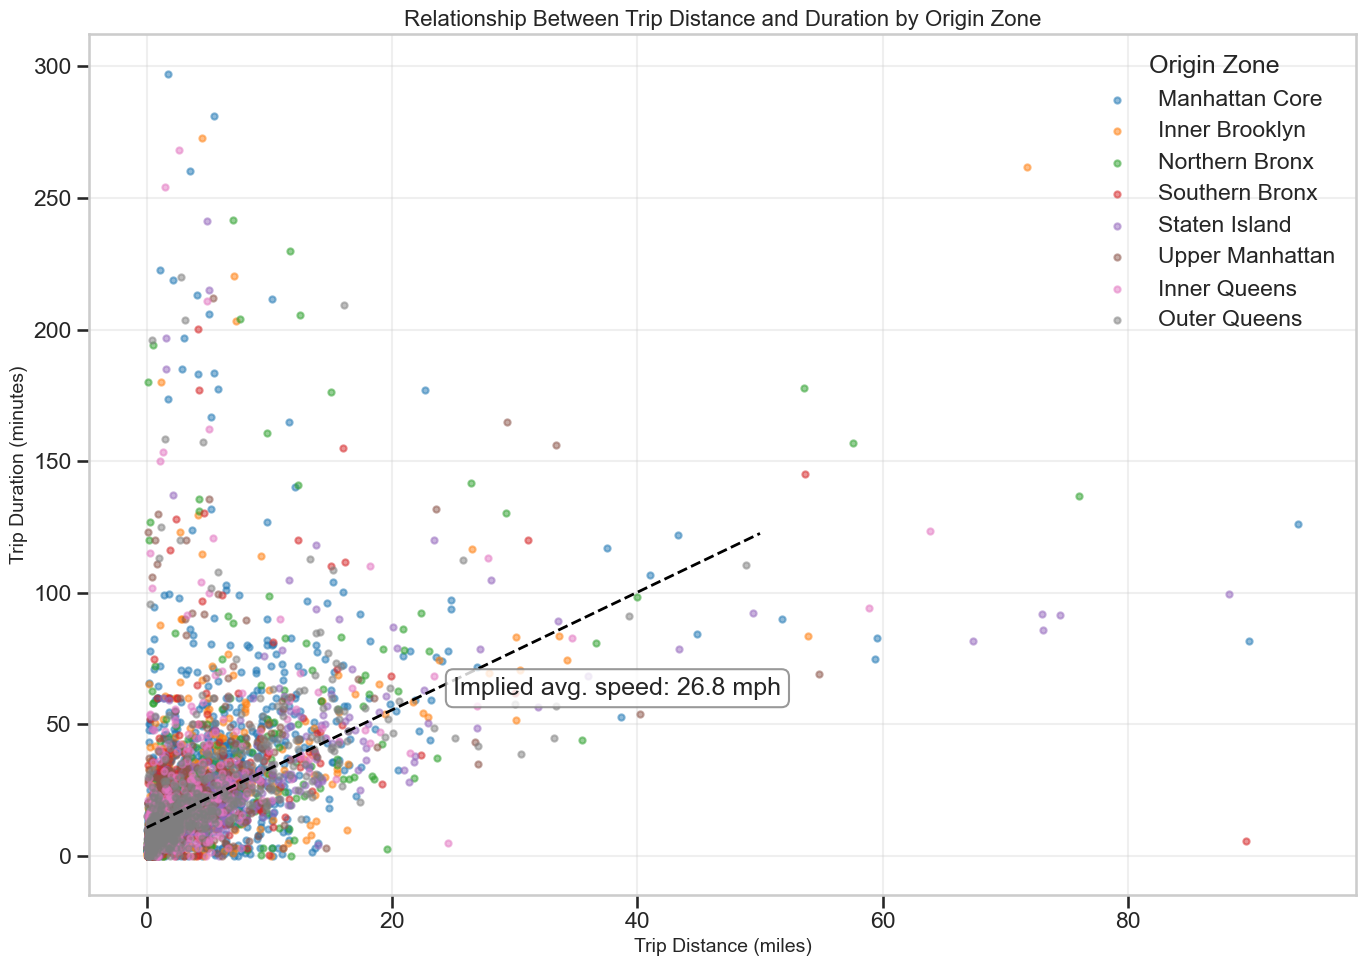

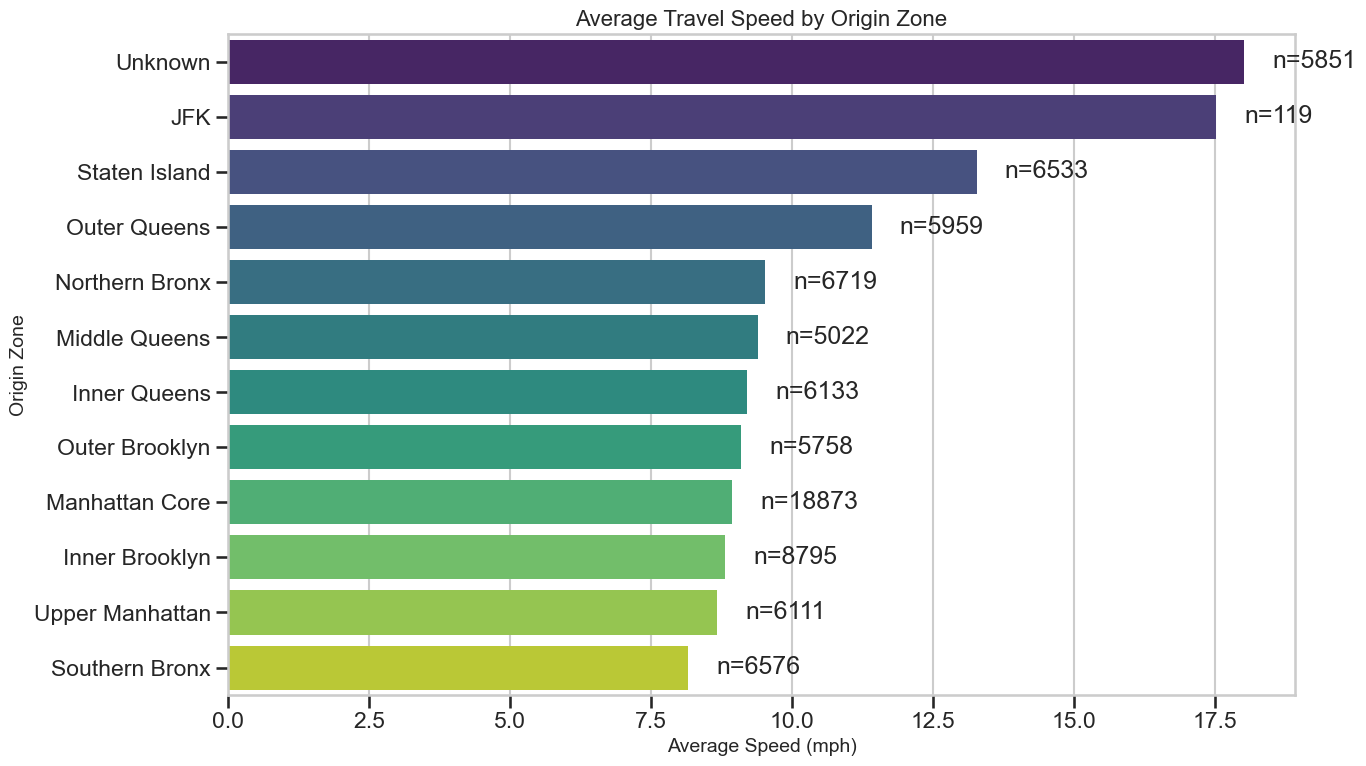

  Analysis 1.3: Relationship between trip distance and duration - Complete


In [15]:
#--------------------------------------------------------------------------
# Theme 1: The Geography of Movement - Spatial Patterns in NYC Transportation
#--------------------------------------------------------------------------
print("\nTheme 1: Analyzing spatial patterns in NYC transportation...")

# Analysis 1.1: Trip duration by origin zone
def analyze_trip_duration_by_zone():
    # Make sure trip_duration is numeric
    clean_trips['trip_duration'] = pd.to_numeric(clean_trips['trip_duration'], errors='coerce')
    
    # Group by origin zone and calculate mean duration
    duration_by_zone = clean_trips.groupby('o_cms_zone')['trip_duration'].agg(['mean', 'median', 'count']).reset_index()
    duration_by_zone = duration_by_zone.sort_values('mean', ascending=False)
    
    # Filter to zones with sufficient data
    min_trips = 100  # Minimum number of trips for inclusion
    duration_by_zone_filtered = duration_by_zone[duration_by_zone['count'] >= min_trips]
    
    # Create visualization
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='mean', y='o_cms_zone', data=duration_by_zone_filtered, palette='viridis')
    plt.title('Average Trip Duration by Origin Zone', fontsize=16)
    plt.xlabel('Average Trip Duration (minutes)', fontsize=14)
    plt.ylabel('Origin Zone', fontsize=14)
    
    # Add count annotations
    for i, row in enumerate(duration_by_zone_filtered.itertuples()):
        plt.text(row.mean + 1, i, f"n={row.count}", va='center')
    
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/1_1_trip_duration_by_zone.png', dpi=300)
    plt.show()  # Changed from plt.close() to display the visualization
    
    print("  Analysis 1.1: Trip duration by origin zone - Complete")
    return duration_by_zone_filtered

# Analysis 1.2: Trip distance by origin zone
def analyze_trip_distance_by_zone():
    # Make sure trip_distance is numeric
    clean_trips['trip_distance'] = pd.to_numeric(clean_trips['trip_distance'], errors='coerce')
    
    # Group by origin zone and calculate mean distance
    distance_by_zone = clean_trips.groupby('o_cms_zone')['trip_distance'].agg(['mean', 'median', 'count']).reset_index()
    distance_by_zone = distance_by_zone.sort_values('mean', ascending=False)
    
    # Filter to zones with sufficient data
    min_trips = 100  # Minimum number of trips for inclusion
    distance_by_zone_filtered = distance_by_zone[distance_by_zone['count'] >= min_trips]
    
    # Create visualization
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='mean', y='o_cms_zone', data=distance_by_zone_filtered, palette='viridis')
    plt.title('Average Trip Distance by Origin Zone', fontsize=16)
    plt.xlabel('Average Trip Distance (miles)', fontsize=14)
    plt.ylabel('Origin Zone', fontsize=14)
    
    # Add count annotations
    for i, row in enumerate(distance_by_zone_filtered.itertuples()):
        plt.text(row.mean + 0.2, i, f"n={row.count}", va='center')
    
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/1_2_trip_distance_by_zone.png', dpi=300)
    plt.show()  # Changed from plt.close() to display the visualization
    
    print("  Analysis 1.2: Trip distance by origin zone - Complete")
    return distance_by_zone_filtered

# Analysis 1.3: Relationship between trip distance and duration
def analyze_distance_duration_relationship():
    # Ensure both columns are numeric
    clean_trips['trip_distance'] = pd.to_numeric(clean_trips['trip_distance'], errors='coerce')
    clean_trips['trip_duration'] = pd.to_numeric(clean_trips['trip_duration'], errors='coerce')
    
    # Remove missing values and outliers for better visualization
    valid_data = clean_trips[
        (clean_trips['trip_distance'].notna()) & 
        (clean_trips['trip_duration'].notna()) &
        (clean_trips['trip_distance'] < 100) &  # Filter extreme distances
        (clean_trips['trip_duration'] < 300)     # Filter extreme durations (5 hours)
    ]
    
    # Sample data for better visualization
    if len(valid_data) > 10000:
        sample_df = valid_data.sample(n=10000, random_state=42)
    else:
        sample_df = valid_data
    
    # Get top zones by frequency for coloring (limit to top 8 for readability)
    top_zones = valid_data['o_cms_zone'].value_counts().head(8).index.tolist()
    sample_df_filtered = sample_df[sample_df['o_cms_zone'].isin(top_zones)]
    
    # Create scatter plot
    plt.figure(figsize=(14, 10))
    
    # Plot each zone with a different color
    for zone in top_zones:
        zone_data = sample_df_filtered[sample_df_filtered['o_cms_zone'] == zone]
        plt.scatter(zone_data['trip_distance'], zone_data['trip_duration'], 
                   alpha=0.5, label=zone, s=20)
    
    plt.title('Relationship Between Trip Distance and Duration by Origin Zone', fontsize=16)
    plt.xlabel('Trip Distance (miles)', fontsize=14)
    plt.ylabel('Trip Duration (minutes)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Origin Zone')
    
    # Add trend line
    try:
        from scipy import stats
        
        # Use cleaned dataset for regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            sample_df_filtered['trip_distance'], 
            sample_df_filtered['trip_duration']
        )
        
        x = np.array([0, min(50, sample_df_filtered['trip_distance'].max())])
        y = intercept + slope * x
        plt.plot(x, y, 'k--', linewidth=2, label=f'Trend (r={r_value:.2f})')
        
        # Add annotation about speed
        speed_mph = 60 / slope  # Convert slope (min/mile) to mph
        plt.annotate(f'Implied avg. speed: {speed_mph:.1f} mph', 
                    xy=(x[1]/2, y[1]/2), 
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    except Exception as e:
        print(f"  Could not calculate trend line: {e}")
    
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/1_3_distance_duration_relationship.png', dpi=300)
    plt.show()
    
    # Create a travel speed analysis
    try:
        # Calculate speed in mph, handling division by zero
        valid_data['speed'] = np.where(
            valid_data['trip_duration'] > 0,
            valid_data['trip_distance'] / (valid_data['trip_duration']/60),
            np.nan
        )
        
        # Filter out unrealistic speeds
        valid_data = valid_data[valid_data['speed'] < 100]
        
        # Group by zone
        zone_speeds = valid_data.groupby('o_cms_zone')['speed'].agg(['mean', 'median', 'count']).reset_index()
        zone_speeds = zone_speeds[zone_speeds['count'] >= 100].sort_values('mean', ascending=False)
        
        # Visualize
        plt.figure(figsize=(14, 8))
        ax = sns.barplot(x='mean', y='o_cms_zone', data=zone_speeds, palette='viridis')
        plt.title('Average Travel Speed by Origin Zone', fontsize=16)
        plt.xlabel('Average Speed (mph)', fontsize=14)
        plt.ylabel('Origin Zone', fontsize=14)
        
        # Add count annotations
        for i, row in enumerate(zone_speeds.itertuples()):
            plt.text(row.mean + 0.5, i, f"n={row.count}", va='center')
            
        plt.tight_layout()
        plt.savefig('nyc_transit_analysis/1_3b_travel_speed_by_zone.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"  Could not create speed analysis: {e}")
        zone_speeds = None
    
    print("  Analysis 1.3: Relationship between trip distance and duration - Complete")
    return zone_speeds

# Run Theme 1 analyses
trip_duration_by_zone = analyze_trip_duration_by_zone()
trip_distance_by_zone = analyze_trip_distance_by_zone()
zone_speeds = analyze_distance_duration_relationship()


Theme 2: Analyzing origin-destination flows and connectivity...


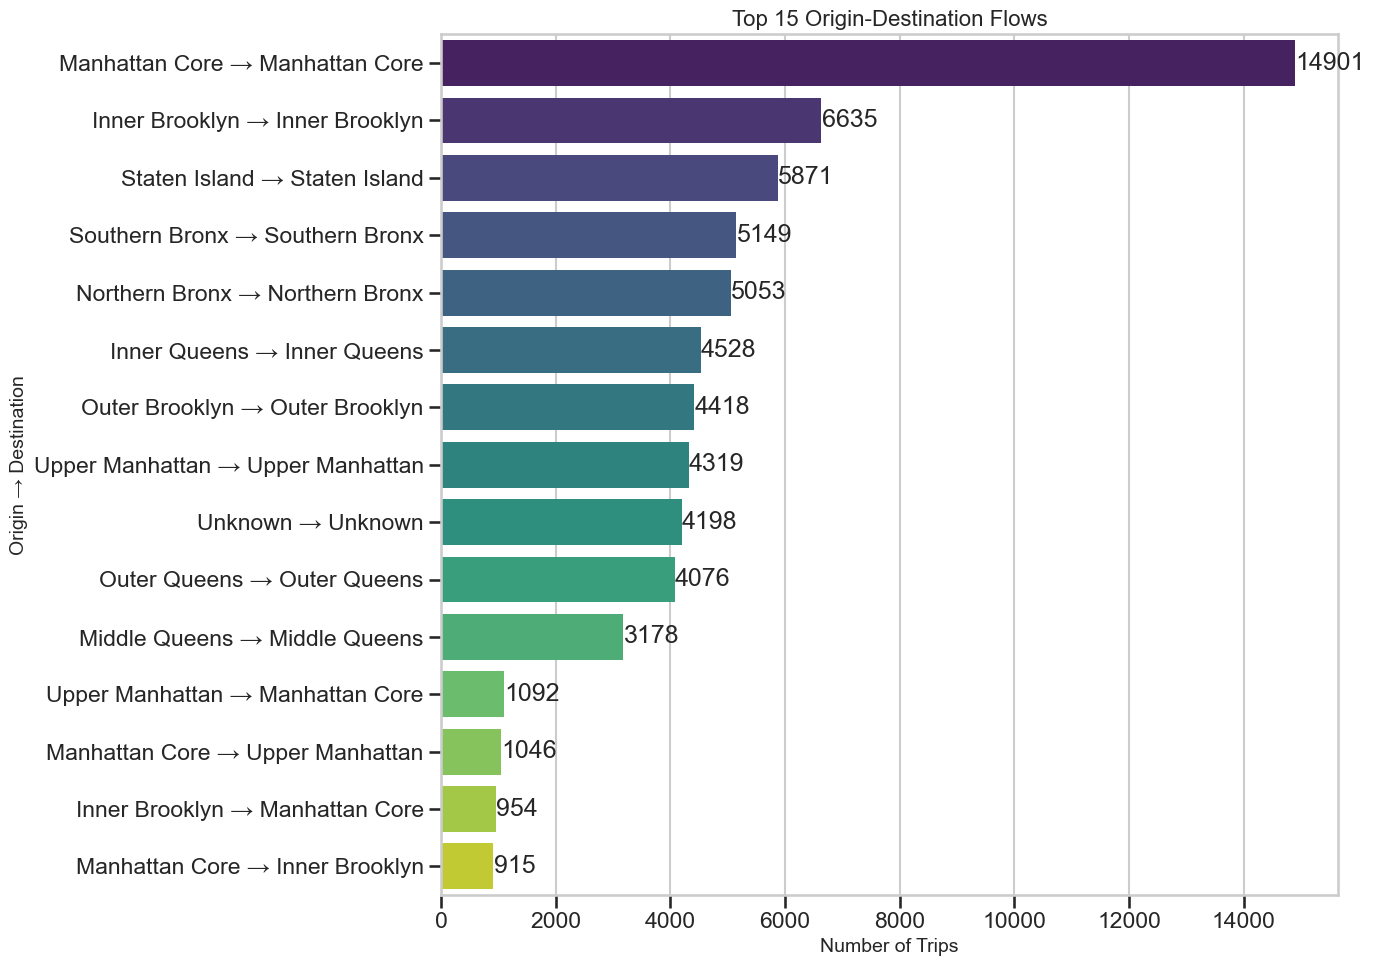

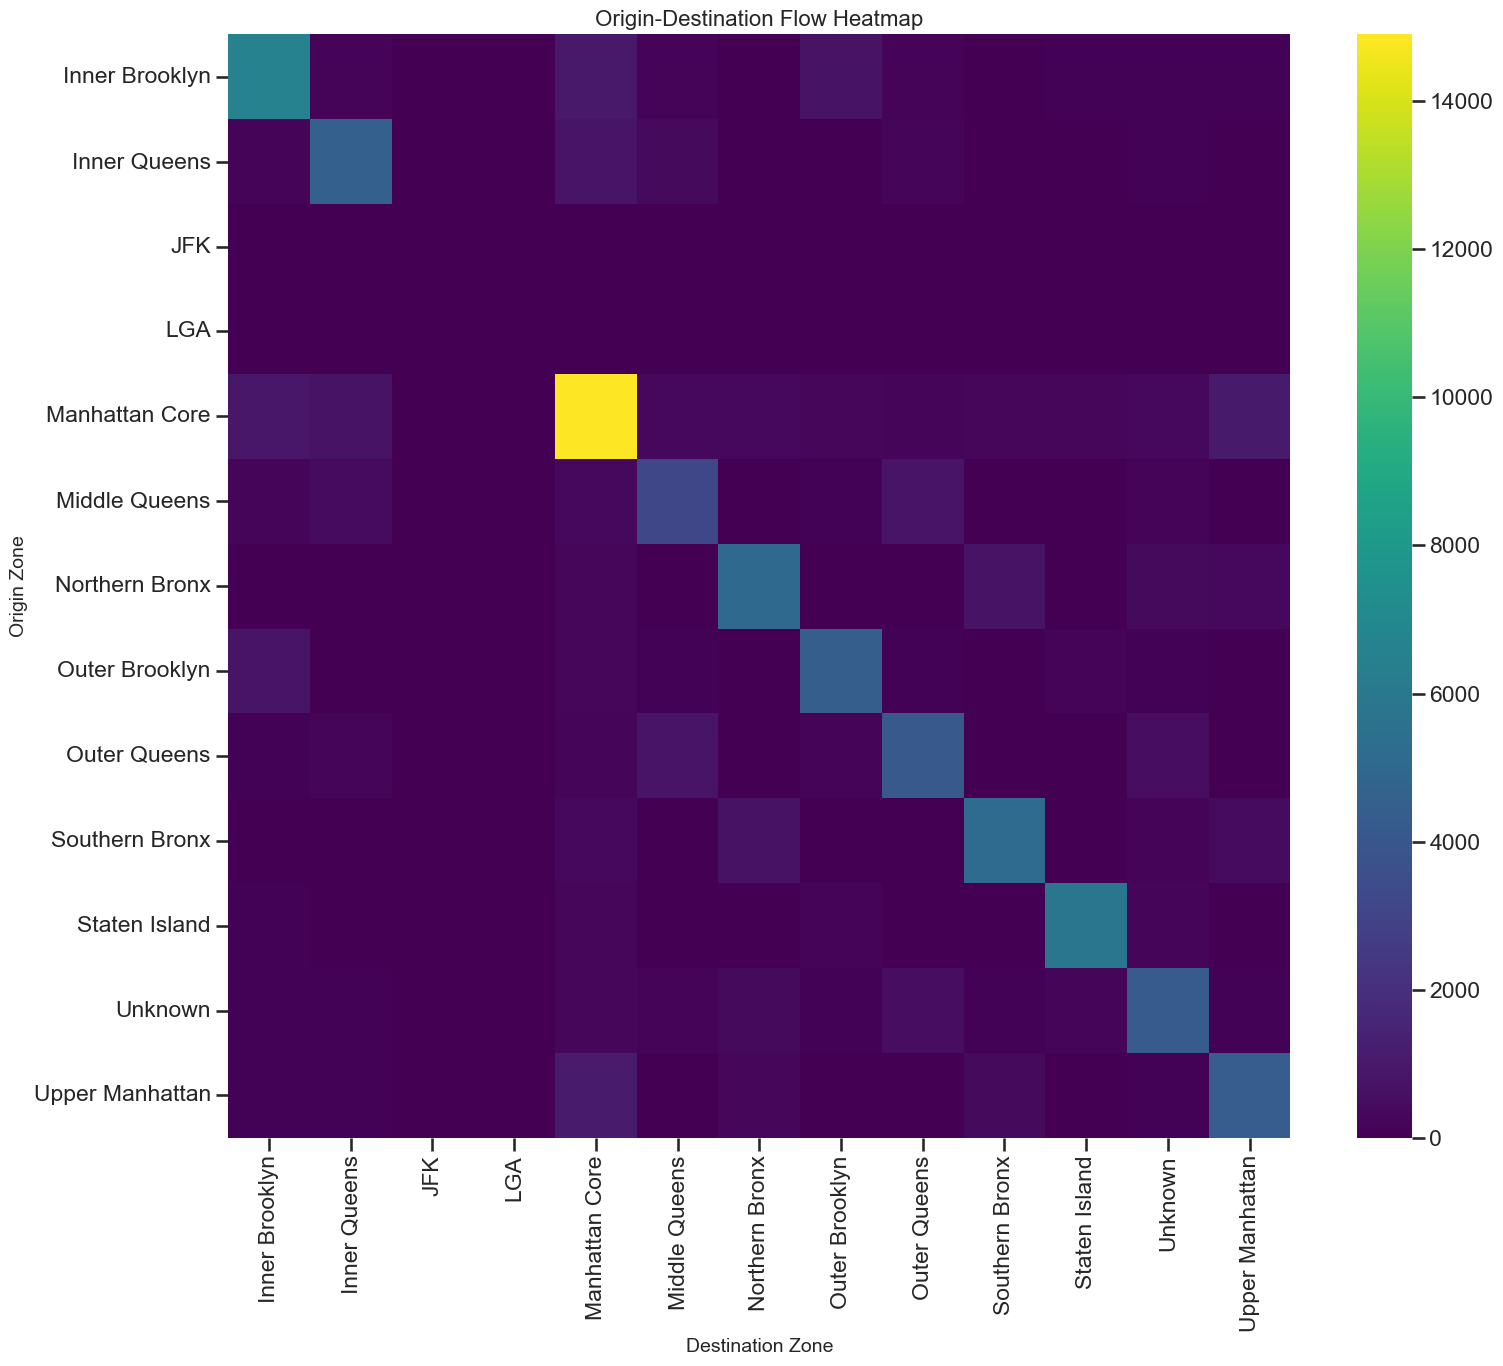

  Analysis 2.1: Major origin-destination flows - Complete


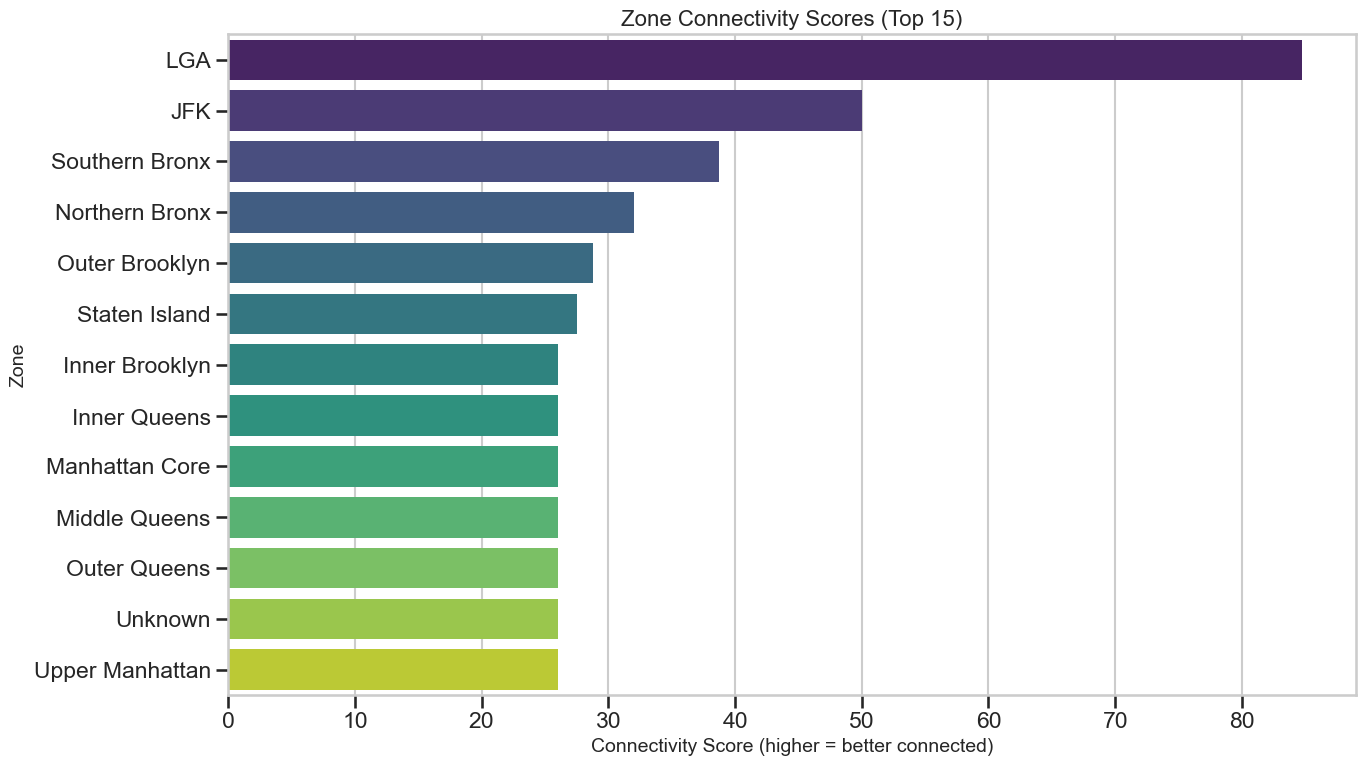

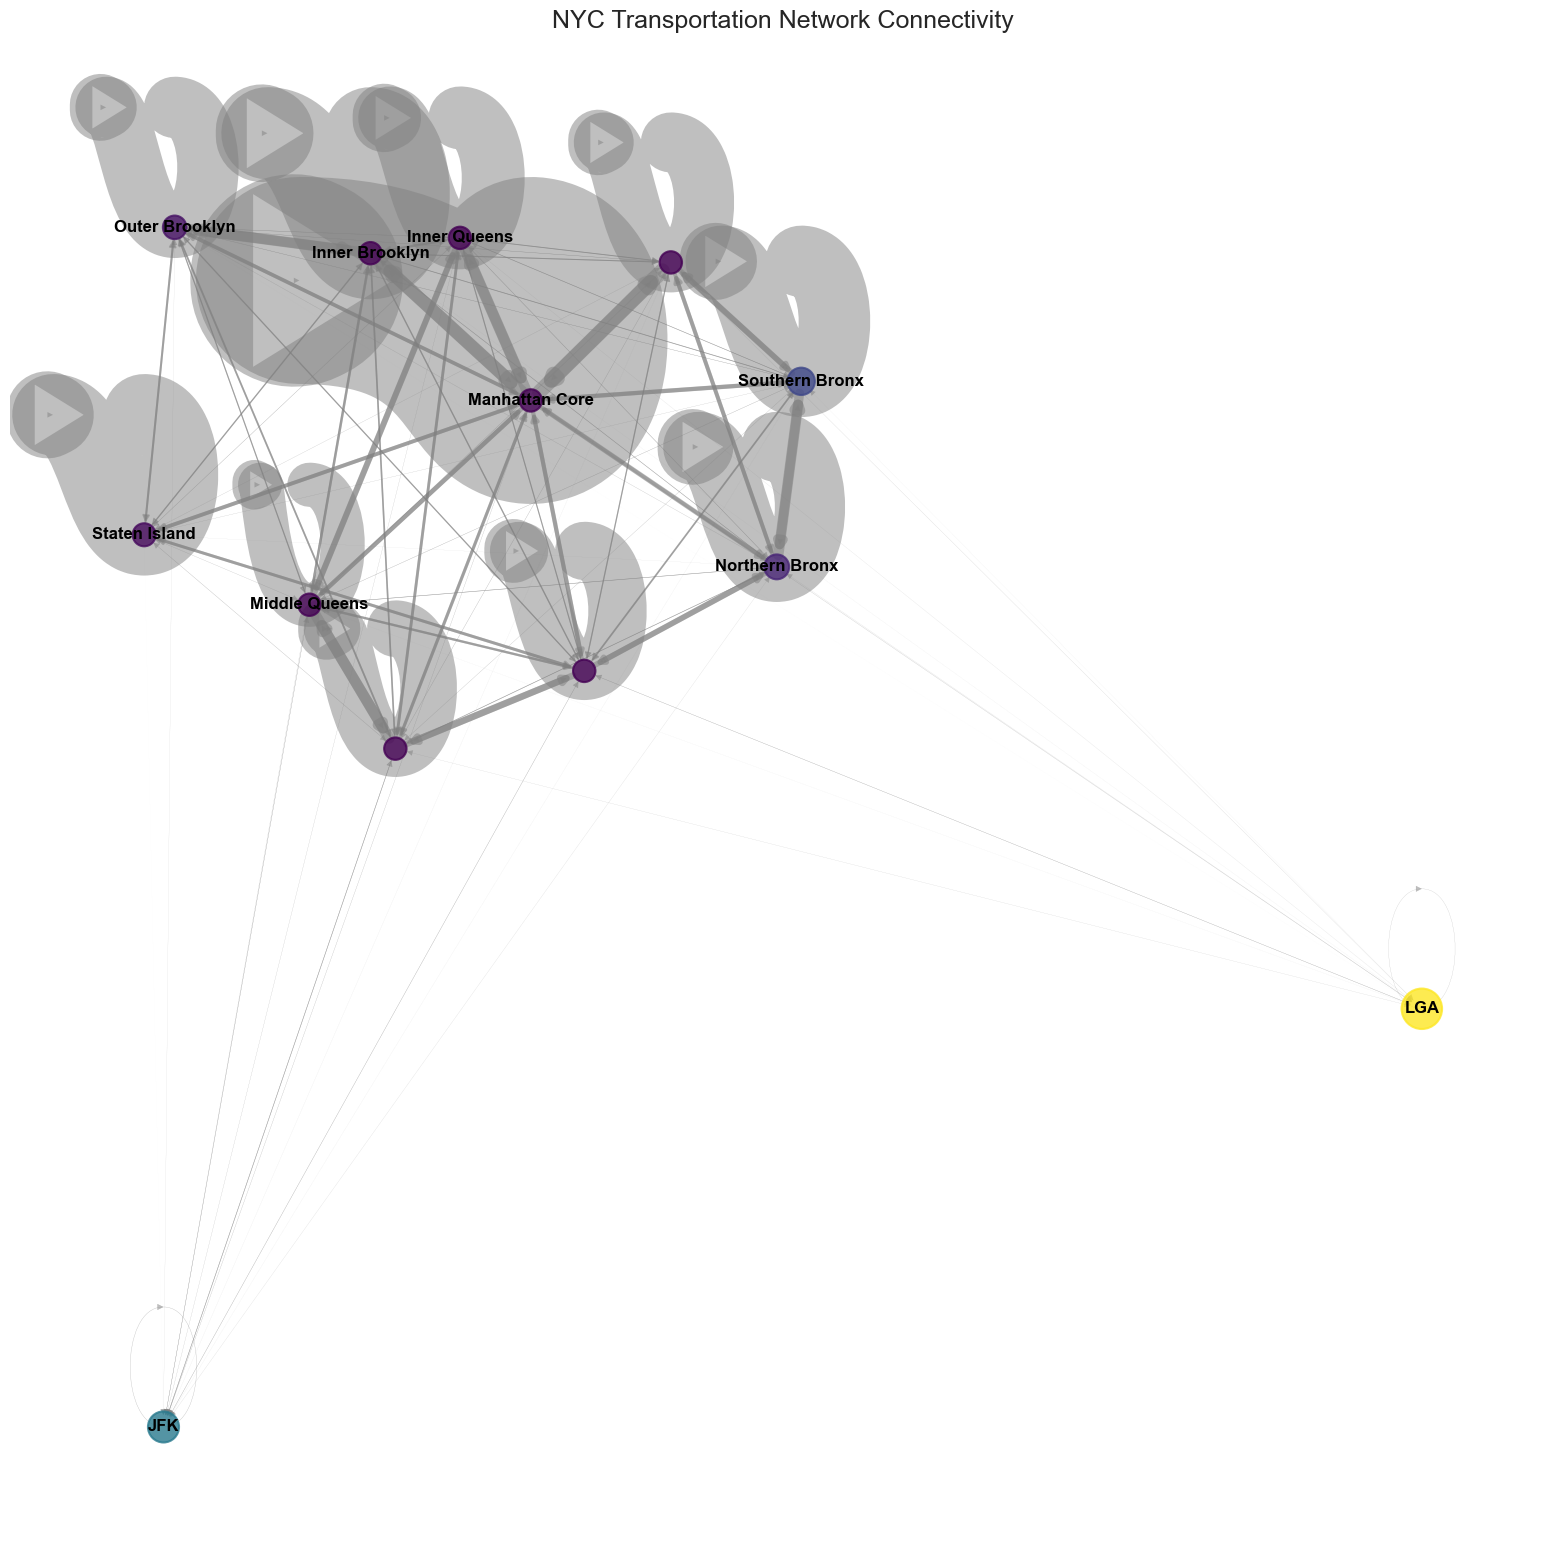

  Analysis 2.2: Network analysis of zone connectivity - Complete
  Plotly visualization failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



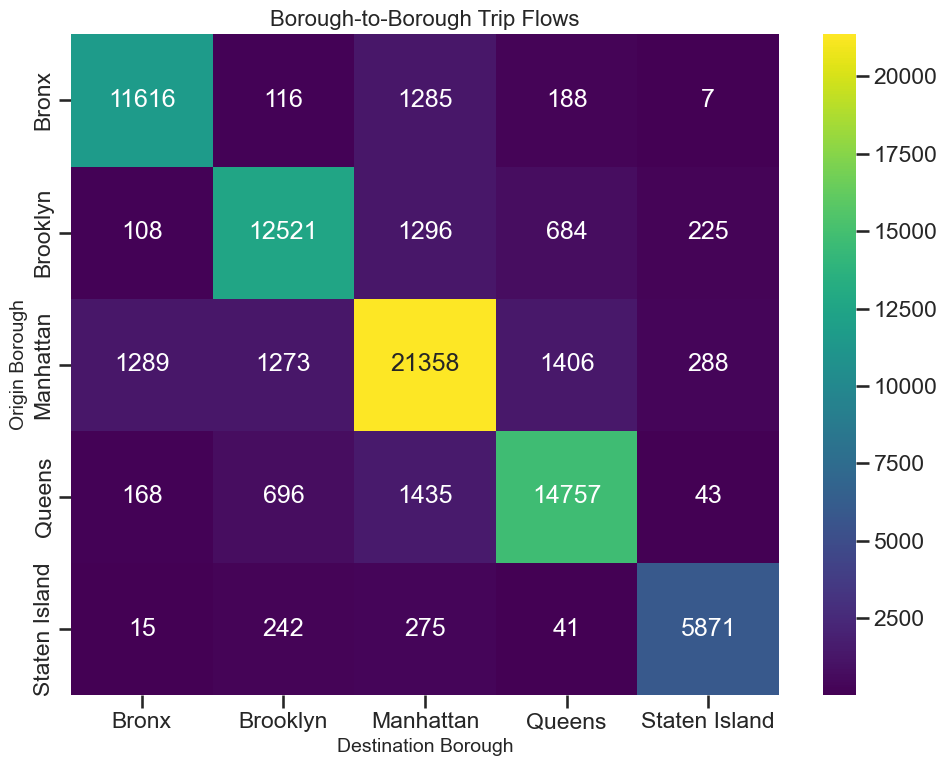

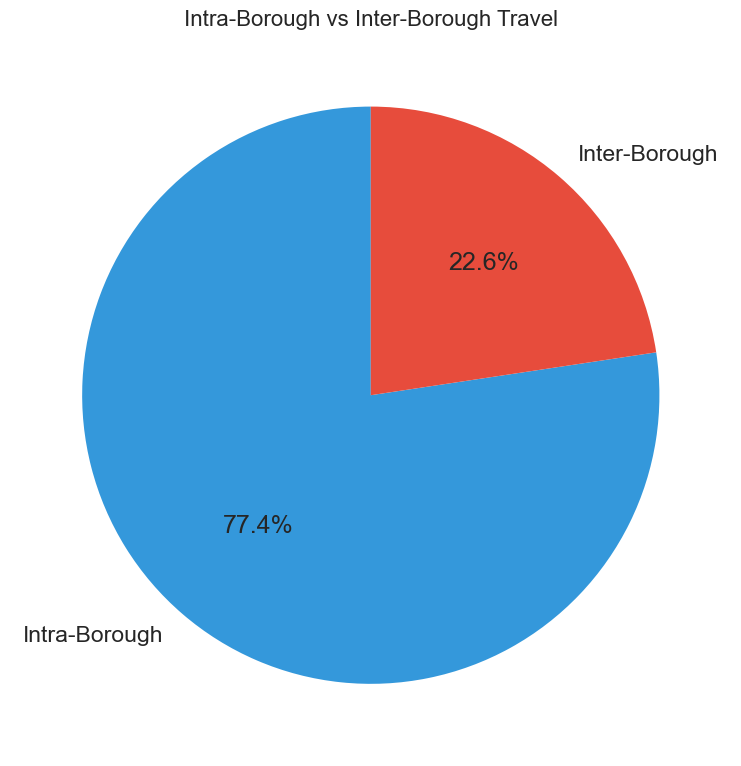

  Analysis 2.3: Borough-level flow analysis - Complete


In [16]:
#--------------------------------------------------------------------------
# Theme 2: City in Motion - Origin-Destination Flows and Connectivity
#--------------------------------------------------------------------------
print("\nTheme 2: Analyzing origin-destination flows and connectivity...")

# Analysis 2.1: Major origin-destination pairs
def analyze_major_od_flows():
    # Group by origin-destination pair
    od_flows = clean_trips.groupby(['o_cms_zone', 'd_cms_zone']).size().reset_index(name='trip_count')
    od_flows = od_flows.sort_values('trip_count', ascending=False)
    
    # Create a combined field for the OD pair
    od_flows['od_pair'] = od_flows['o_cms_zone'] + ' → ' + od_flows['d_cms_zone']
    
    # Visualize top 15 OD pairs
    plt.figure(figsize=(14, 10))
    top_n = 15
    top_flows = od_flows.head(top_n)
    
    ax = sns.barplot(x='trip_count', y='od_pair', data=top_flows, palette='viridis')
    plt.title(f'Top {top_n} Origin-Destination Flows', fontsize=16)
    plt.xlabel('Number of Trips', fontsize=14)
    plt.ylabel('Origin → Destination', fontsize=14)
    
    # Add count annotations
    for i, count in enumerate(top_flows['trip_count']):
        plt.text(count + 5, i, f"{count}", va='center')
    
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/2_1_major_od_flows.png', dpi=300)
    plt.show()  # Changed from plt.close()
    
    # Create a heatmap of all OD pairs
    od_matrix = pd.pivot_table(od_flows, values='trip_count', 
                              index='o_cms_zone', columns='d_cms_zone', 
                              fill_value=0)
    
    plt.figure(figsize=(16, 14))
    # Changed fmt='d' to fmt='.0f' to handle float values
    sns.heatmap(od_matrix, cmap='viridis', annot=False, fmt='.0f')
    plt.title('Origin-Destination Flow Heatmap', fontsize=16)
    plt.xlabel('Destination Zone', fontsize=14)
    plt.ylabel('Origin Zone', fontsize=14)
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/2_1b_od_heatmap.png', dpi=300)
    plt.show()  # Changed from plt.close()
    
    print("  Analysis 2.1: Major origin-destination flows - Complete")
    return od_flows

# Analysis 2.2: Network analysis of zone connectivity
def analyze_zone_connectivity():
    # Create a network graph of zone connectivity
    od_flows = clean_trips.groupby(['o_cms_zone', 'd_cms_zone']).size().reset_index(name='trip_count')
    
    # Create a network graph
    G = nx.DiGraph()
    
    # Add edges with weights based on trip count
    for _, row in od_flows.iterrows():
        G.add_edge(row['o_cms_zone'], row['d_cms_zone'], weight=row['trip_count'])
    
    # Calculate network metrics
    # In-degree (number of incoming connections)
    in_degree = dict(G.in_degree())
    # Out-degree (number of outgoing connections)
    out_degree = dict(G.out_degree())
    # Betweenness centrality (measure of node importance for connections)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    
    # Combine metrics
    network_metrics = pd.DataFrame({
        'zone': list(in_degree.keys()),
        'in_degree': list(in_degree.values()),
        'out_degree': list(out_degree.values()),
        'betweenness': list(betweenness.values())
    })
    
    network_metrics['connectivity_score'] = (
        network_metrics['in_degree'] + 
        network_metrics['out_degree'] + 
        network_metrics['betweenness'] * 100
    )
    
    network_metrics = network_metrics.sort_values('connectivity_score', ascending=False)
    
    # Visualize connectivity scores
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='connectivity_score', y='zone', data=network_metrics.head(15), palette='viridis')
    plt.title('Zone Connectivity Scores (Top 15)', fontsize=16)
    plt.xlabel('Connectivity Score (higher = better connected)', fontsize=14)
    plt.ylabel('Zone', fontsize=14)
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/2_2_zone_connectivity.png', dpi=300)
    plt.show()  # Changed from plt.close()
    
    # Create network visualization
    plt.figure(figsize=(16, 16))
    
    # Use connectivity score for node size and color
    node_size = {zone: score*10 for zone, score in zip(network_metrics['zone'], network_metrics['connectivity_score'])}
    
    # Layout
    pos = nx.spring_layout(G, k=0.15, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                         node_size=[node_size.get(node, 100) for node in G.nodes()],
                         node_color=list(network_metrics.set_index('zone').loc[list(G.nodes())]['connectivity_score']),
                         cmap='viridis',
                         alpha=0.8)
    
    # Draw edges with varying width based on trip count
    edges = G.edges()
    weights = [G[u][v]['weight']/100 for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5, edge_color='gray', arrows=True, arrowsize=10)
    
    # Draw labels for top connected nodes only
    top_nodes = network_metrics.head(10)['zone'].tolist()
    labels = {node: node for node in G.nodes() if node in top_nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_weight='bold')
    
    plt.title('NYC Transportation Network Connectivity', fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/2_2b_network_visualization.png', dpi=300)
    plt.show()  # Changed from plt.close()
    
    print("  Analysis 2.2: Network analysis of zone connectivity - Complete")
    return network_metrics

# Analysis 2.3: Borough-level flow analysis
def analyze_borough_flows():
    # Map zones to boroughs (you may need to adjust this based on actual zone names)
    borough_mapping = {
        'Manhattan Core': 'Manhattan',
        'Upper Manhattan': 'Manhattan',
        'Inner Brooklyn': 'Brooklyn',
        'Outer Brooklyn': 'Brooklyn',
        'Inner Queens': 'Queens',
        'Middle Queens': 'Queens',
        'Outer Queens': 'Queens',
        'Northern Bronx': 'Bronx',
        'Southern Bronx': 'Bronx',
        'Staten Island': 'Staten Island',
        'JFK': 'Queens',
        'LGA': 'Queens'
    }
    
    # Add borough columns
    temp_df = clean_trips.copy()
    temp_df['origin_borough'] = temp_df['o_cms_zone'].map(borough_mapping)
    temp_df['destination_borough'] = temp_df['d_cms_zone'].map(borough_mapping)
    
    # Borough-level flow analysis
    borough_flows = temp_df.groupby(['origin_borough', 'destination_borough']).size().reset_index(name='trip_count')
    
    # Create a chord diagram using Plotly
    # This requires Plotly - if not available, can be replaced with a simple heatmap
    try:
        # Create a pivot table for the matrix
        flow_matrix = pd.pivot_table(borough_flows, values='trip_count', 
                                    index='origin_borough', columns='destination_borough', 
                                    fill_value=0)
        
        # Ensure symmetrical matrix (same boroughs in same order)
        all_boroughs = sorted(set(flow_matrix.index) | set(flow_matrix.columns))
        for borough in all_boroughs:
            if borough not in flow_matrix.index:
                flow_matrix.loc[borough] = 0
            if borough not in flow_matrix.columns:
                flow_matrix[borough] = 0
        
        flow_matrix = flow_matrix.reindex(index=all_boroughs, columns=all_boroughs)
        
        # Create the chord diagram using Plotly
        fig = go.Figure(go.Heatmap(
            z=flow_matrix.values,
            x=flow_matrix.columns,
            y=flow_matrix.index,
            colorscale='Viridis',
            colorbar=dict(title='Trip Count'),
        ))
        
        fig.update_layout(
            title='Borough-to-Borough Trip Flows',
            xaxis=dict(title='Destination Borough'),
            yaxis=dict(title='Origin Borough'),
            width=800, height=800
        )
        
        fig.write_image('nyc_transit_analysis/2_3_borough_flows.png')
        fig.show()  # Added to display Plotly figure
        
    except Exception as e:
        print(f"  Plotly visualization failed: {e}")
        # Fallback to matplotlib heatmap
        flow_matrix = pd.pivot_table(borough_flows, values='trip_count', 
                                    index='origin_borough', columns='destination_borough', 
                                    fill_value=0)
        
        plt.figure(figsize=(10, 8))
        # Changed fmt='d' to fmt='.0f' to handle float values
        sns.heatmap(flow_matrix, annot=True, fmt='.0f', cmap='viridis')
        plt.title('Borough-to-Borough Trip Flows', fontsize=16)
        plt.xlabel('Destination Borough', fontsize=14)
        plt.ylabel('Origin Borough', fontsize=14)
        plt.tight_layout()
        plt.savefig('nyc_transit_analysis/2_3_borough_flows.png', dpi=300)
        plt.show()  # Changed from plt.close()
    
    # Calculate intra-borough vs inter-borough travel percentage
    temp_df['intra_borough'] = temp_df['origin_borough'] == temp_df['destination_borough']
    intra_vs_inter = temp_df['intra_borough'].value_counts(normalize=True) * 100
    
    plt.figure(figsize=(8, 8))
    plt.pie(intra_vs_inter, labels=['Intra-Borough', 'Inter-Borough'], autopct='%1.1f%%',
           colors=['#3498db', '#e74c3c'], startangle=90)
    plt.title('Intra-Borough vs Inter-Borough Travel', fontsize=16)
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/2_3b_intra_vs_inter_borough.png', dpi=300)
    plt.show()  # Changed from plt.close()
    
    print("  Analysis 2.3: Borough-level flow analysis - Complete")
    return borough_flows

# Run Theme 2 analyses
od_flows = analyze_major_od_flows()
network_metrics = analyze_zone_connectivity()
borough_flows = analyze_borough_flows()

In [18]:
#--------------------------------------------------------------------------
# Theme 3: Moving Differently - Modal Diversity and Transportation Choice
#--------------------------------------------------------------------------
print("\nTheme 3: Analyzing modal diversity and transportation choice...")



# Analysis 3.2: Modal diversity index
def calculate_modal_diversity():
    # Calculate Shannon diversity index for each zone
    def shannon_diversity(x):
        proportions = x.value_counts(normalize=True)
        return -sum(proportions * np.log(proportions))
    
    # Group by zone and calculate diversity
    modal_diversity = clean_trips.groupby('o_cms_zone')['mode_category'].apply(shannon_diversity).reset_index()
    modal_diversity.columns = ['o_cms_zone', 'diversity_index']
    
    # Add count of trips for reference
    zone_counts = clean_trips.groupby('o_cms_zone').size().reset_index(name='trip_count')
    modal_diversity = modal_diversity.merge(zone_counts, on='o_cms_zone')
    
    # Sort by diversity
    modal_diversity = modal_diversity.sort_values('diversity_index', ascending=False)
    
    # Visualize - HORIZONTAL BAR CHART
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(y='o_cms_zone', x='diversity_index', data=modal_diversity, palette='viridis')
    plt.title('Modal Diversity Index by Origin Zone', fontsize=16)
    plt.ylabel('Origin Zone', fontsize=14)
    plt.xlabel('Diversity Index (higher = more diverse mode options)', fontsize=14)
    
    # Add count annotations
    for i, row in enumerate(modal_diversity.itertuples()):
        plt.text(row.diversity_index + 0.05, i, f"n={row.trip_count}", va='center')
    
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/3_2_modal_diversity.png', dpi=300)
    plt.show()  # Display visualization in notebook
    
    print("  Analysis 3.2: Modal diversity index - Complete")
    return modal_diversity

# Analysis 3.3: Sustainable transportation adoption
def analyze_sustainable_transport():
    # Check if sustainable_mode column exists
    if 'sustainable_mode' not in clean_trips.columns:
        # If not, create it based on mode categories
        sustainable_modes = ['Walk', 'Bike', 'Subway', 'Bus', 'Ferry', 'Commuter Rail']
        clean_trips['is_sustainable'] = clean_trips['mode_category'].isin(sustainable_modes)
    else:
        # Convert existing column to boolean if needed
        clean_trips['is_sustainable'] = clean_trips['sustainable_mode'] == 1
    
    # Calculate sustainable mode percentage by zone
    sustainable_by_zone = clean_trips.groupby('o_cms_zone')['is_sustainable'].mean() * 100
    sustainable_by_zone = sustainable_by_zone.reset_index()
    sustainable_by_zone.columns = ['o_cms_zone', 'sustainable_percentage']
    
    # Sort by percentage
    sustainable_by_zone = sustainable_by_zone.sort_values('sustainable_percentage', ascending=False)
    
    # Visualize - HORIZONTAL BAR CHART
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(y='o_cms_zone', x='sustainable_percentage', data=sustainable_by_zone, palette='viridis')
    plt.title('Sustainable Transportation Adoption by Origin Zone', fontsize=16)
    plt.ylabel('Origin Zone', fontsize=14)
    plt.xlabel('Percentage of Sustainable Trips', fontsize=14)
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/3_3_sustainable_transport.png', dpi=300)
    plt.show()  # Display visualization in notebook
    
    # Add a line chart visualization of sustainable transport by time of day
    if 'depart_hour' in clean_trips.columns:
        # Group trips by hour and calculate sustainable percentage
        sustainable_by_hour = clean_trips.groupby('depart_hour')['is_sustainable'].mean() * 100
        sustainable_by_hour = sustainable_by_hour.reset_index()
        
        plt.figure(figsize=(12, 6))
        ax = sns.lineplot(x='depart_hour', y='is_sustainable', data=sustainable_by_hour, 
                         marker='o', color='#2ecc71', linewidth=2)
        plt.title('Sustainable Transportation Use by Hour of Day', fontsize=16)
        plt.xlabel('Hour of Day (24-hour)', fontsize=14)
        plt.ylabel('Percentage of Sustainable Trips', fontsize=14)
        plt.xticks(range(0, 24))
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('nyc_transit_analysis/3_3b_sustainable_by_hour.png', dpi=300)
        plt.show()  # Display visualization in notebook
    
    print("  Analysis 3.3: Sustainable transportation adoption - Complete")
    return sustainable_by_zone

# Analysis 3.4: Mode choice by trip purpose
def analyze_mode_by_purpose():
    # Check if we have purpose data
    if 'd_purpose_category' not in clean_trips.columns:
        print("  Trip purpose data not available - skipping analysis 3.4")
        return None
    
    # Create purpose mapping
    purpose_map = {
        1: 'Home',
        2: 'Work',
        3: 'School',
        4: 'Shopping',
        5: 'Personal Business',
        6: 'Social/Recreation',
        7: 'Medical',
        8: 'Transport Someone',
        9: 'Meal',
        10: 'Religious',
        11: 'Other'
    }
    
    # Apply mapping
    clean_trips['trip_purpose'] = clean_trips['d_purpose_category'].map(purpose_map)
    
    # Create crosstab of mode by purpose
    mode_by_purpose = pd.crosstab(
        clean_trips['trip_purpose'], 
        clean_trips['mode_category'],
        normalize='index'
    ) * 100
    
    # Visualize - HORIZONTAL BAR CHART WITH MUCH LONGER BARS
    plt.figure(figsize=(30, 12))  # Dramatically increased width to 30
    ax = mode_by_purpose.plot(kind='barh', stacked=True, colormap='viridis', width=0.8)
    plt.title('Transportation Mode Choice by Trip Purpose', fontsize=18)
    plt.ylabel('Trip Purpose', fontsize=16)
    plt.xlabel('Percentage', fontsize=16)
    plt.xlim(0, 105)  # Extend slightly past 100% to give space at the end
    
    # Increase font sizes for better readability
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Ensure full legend and adjust position to not overlap with the expanded chart
    plt.legend(title='Mode Type', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=14, title_fontsize=16)
    
    # Set figure layout to use maximum space
    plt.subplots_adjust(left=0.1, right=0.8)  # Leave 20% of width for legend
    plt.savefig('nyc_transit_analysis/3_4_mode_by_purpose.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display visualization in notebook
    
    # Also create a simplified version with mode groups
    if 'mode_group' in clean_trips.columns:
        mode_group_by_purpose = pd.crosstab(
            clean_trips['trip_purpose'], 
            clean_trips['mode_group'],
            normalize='index'
        ) * 100
        
        plt.figure(figsize=(30, 12))  # Dramatically increased width
        ax = mode_group_by_purpose.plot(kind='barh', stacked=True, colormap='viridis', width=0.8)
        plt.title('Transportation Mode Groups by Trip Purpose', fontsize=18)
        plt.ylabel('Trip Purpose', fontsize=16)
        plt.xlabel('Percentage', fontsize=16)
        plt.xlim(0, 105)  # Extend slightly past 100%
        
        # Increase font sizes
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        plt.legend(title='Mode Group', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=14, title_fontsize=16)
        plt.subplots_adjust(left=0.1, right=0.8)
        plt.savefig('nyc_transit_analysis/3_4b_mode_group_by_purpose.png', dpi=300, bbox_inches='tight')
        plt.show()  # Display visualization in notebook
    
    print("  Analysis 3.4: Mode choice by trip purpose - Complete")
    return mode_by_purpose

# Analysis 3.5: Trip distance by mode
def analyze_distance_by_mode():
    # Ensure trip_distance is numeric
    clean_trips['trip_distance'] = pd.to_numeric(clean_trips['trip_distance'], errors='coerce')
    
    # Remove extreme outliers
    valid_trips = clean_trips[clean_trips['trip_distance'] < 100]
    
    # Calculate average distance by mode
    distance_by_mode = valid_trips.groupby('mode_category')['trip_distance'].agg(['mean', 'median', 'count']).reset_index()
    distance_by_mode = distance_by_mode.sort_values('mean', ascending=False)
    
    # Filter to modes with enough data
    min_trips = 50
    distance_by_mode_filtered = distance_by_mode[distance_by_mode['count'] >= min_trips]
    
    # Visualize - HORIZONTAL BAR CHART
    plt.figure(figsize=(12, 10))
    ax = sns.barplot(y='mode_category', x='mean', data=distance_by_mode_filtered, palette='viridis')
    plt.title('Average Trip Distance by Transportation Mode', fontsize=16)
    plt.ylabel('Mode Type', fontsize=14)
    plt.xlabel('Average Trip Distance (miles)', fontsize=14)
    
    # Add count annotations
    for i, row in enumerate(distance_by_mode_filtered.itertuples()):
        plt.text(row.mean + 0.5, i, f"n={row.count}", va='center')
    
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/3_5_distance_by_mode.png', dpi=300)
    plt.show()  # Display visualization in notebook
    
    # Create a violin plot to show distribution - Keep vertical for violin plot
    plt.figure(figsize=(14, 8))
    # Cap y-axis for better visualization
    sns.violinplot(x='mode_category', y='trip_distance', data=valid_trips[valid_trips['trip_distance'] < 20], 
                  palette='viridis', inner='quartile', order=distance_by_mode_filtered['mode_category'])
    plt.title('Distribution of Trip Distances by Transportation Mode', fontsize=16)
    plt.xlabel('Mode Type', fontsize=14)
    plt.ylabel('Trip Distance (miles, capped at 20)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/3_5b_distance_distribution_by_mode.png', dpi=300)
    plt.show()  # Display visualization in notebook
    
    print("  Analysis 3.5: Trip distance by mode - Complete")
    return distance_by_mode_filtered

# Run Theme 3 analyses
mode_by_zone_results = analyze_mode_by_zone()
modal_diversity_results = calculate_modal_diversity()
sustainable_transport_results = analyze_sustainable_transport()
mode_by_purpose_results = analyze_mode_by_purpose()
distance_by_mode_results = analyze_distance_by_mode()


Theme 3: Analyzing modal diversity and transportation choice...


NameError: name 'analyze_mode_by_zone' is not defined


Theme 5: Analyzing trip purpose patterns...


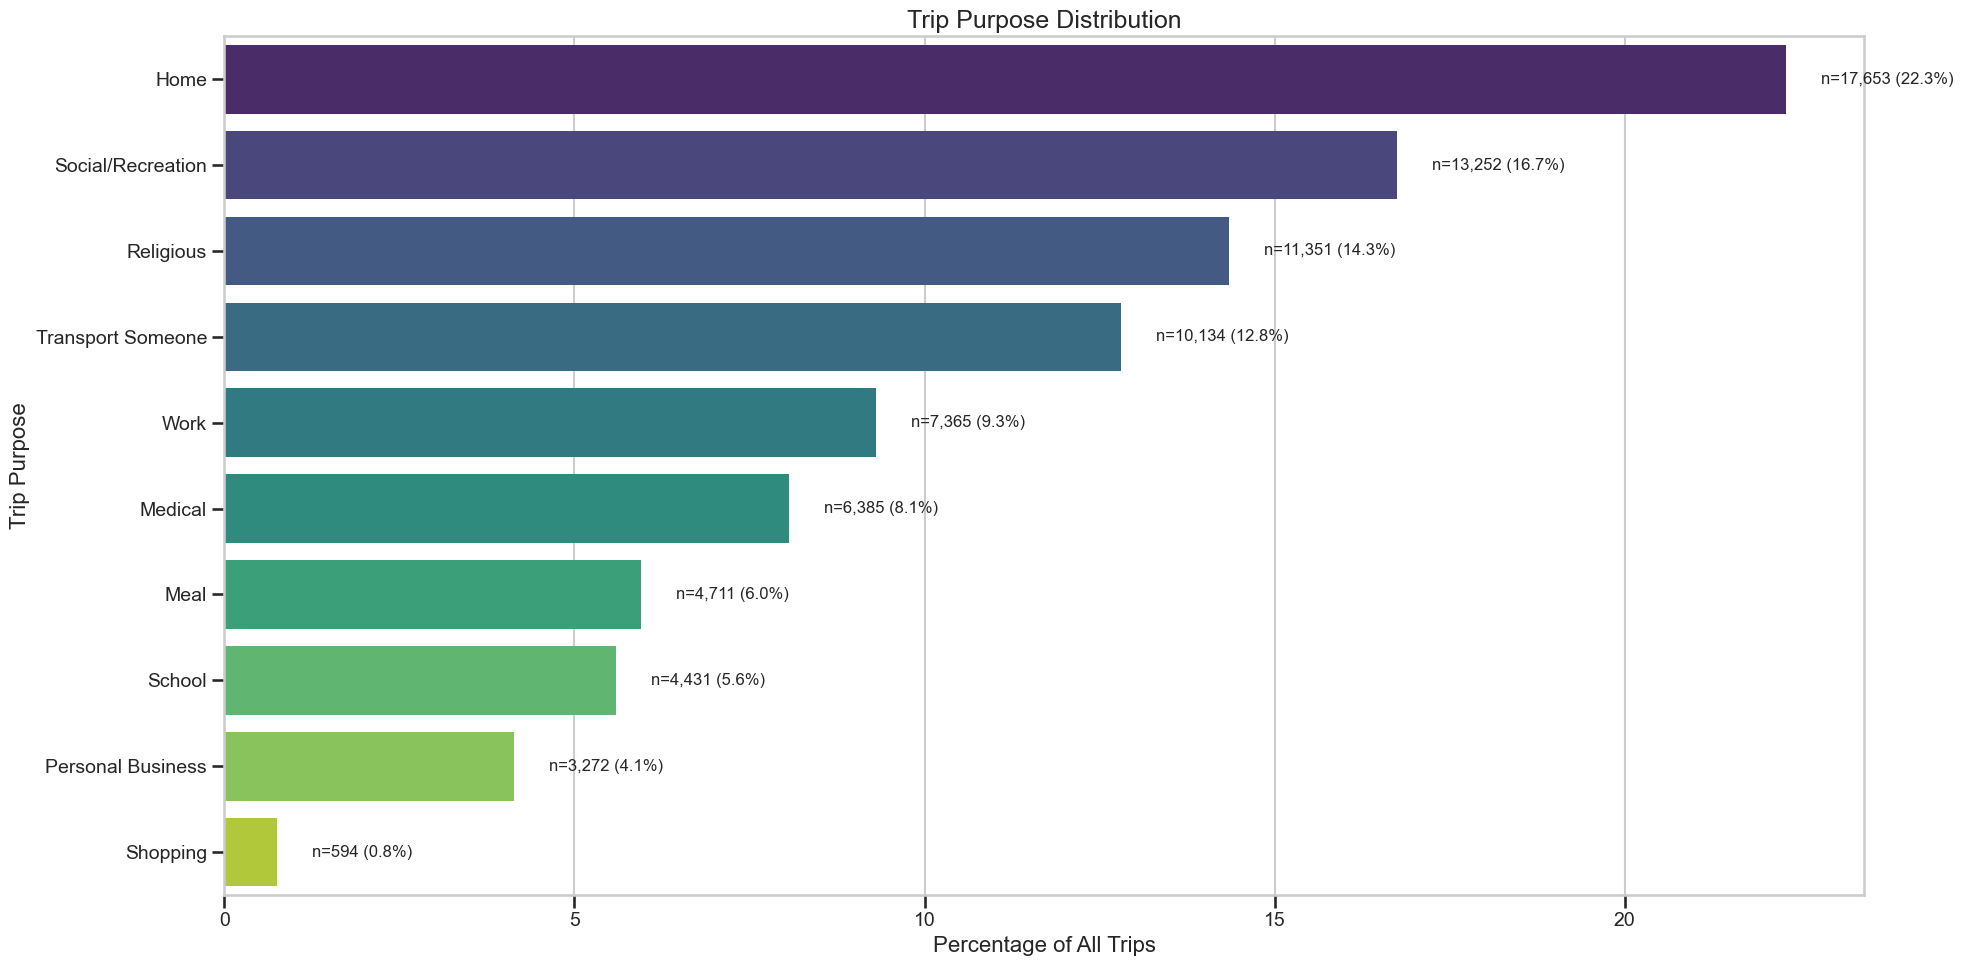

<Figure size 3000x1400 with 0 Axes>

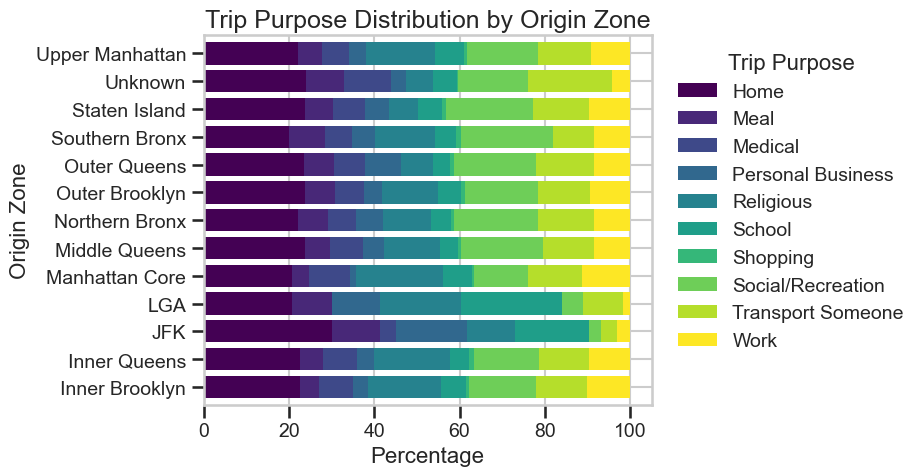

<Figure size 3000x1200 with 0 Axes>

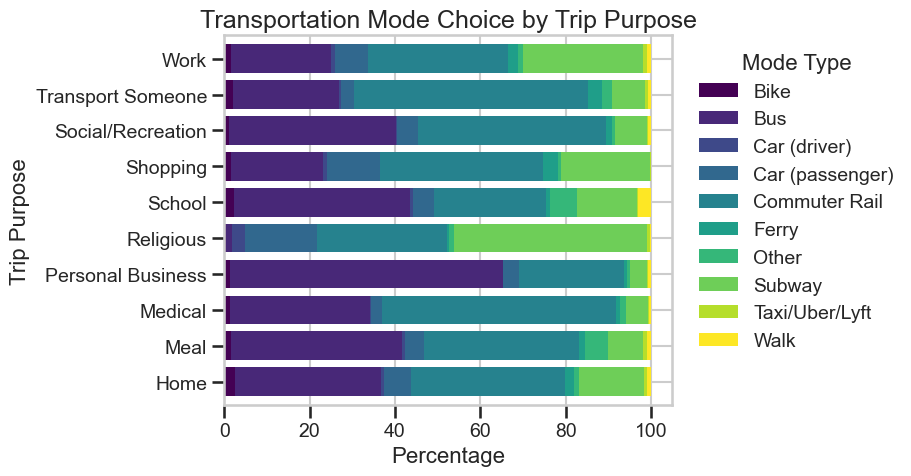

  Analysis 5.1: Trip purpose distribution - Complete


In [22]:
#--------------------------------------------------------------------------
# Theme 5: Purpose - Why NYC Moves
#--------------------------------------------------------------------------
print("\nTheme 5: Analyzing trip purpose patterns...")

# Analysis 5.1: Trip purpose distribution
def analyze_trip_purpose():
    # Check if purpose columns exist
    if 'd_purpose_category' not in clean_trips.columns:
        print("  Purpose columns not available - skipping analysis 5.1")
        return None
    
    # Create purpose mapping
    purpose_map = {
        1: 'Home',
        2: 'Work',
        3: 'School',
        4: 'Shopping',
        5: 'Personal Business',
        6: 'Social/Recreation',
        7: 'Medical',
        8: 'Transport Someone',
        9: 'Meal',
        10: 'Religious',
        11: 'Other'
    }
    
    # Apply mapping
    clean_trips['trip_purpose'] = clean_trips['d_purpose_category'].map(purpose_map)
    
    # Analyze trip purposes
    purpose_counts = clean_trips['trip_purpose'].value_counts().reset_index()
    purpose_counts.columns = ['purpose', 'count']
    
    # Calculate percentage
    purpose_counts['percentage'] = purpose_counts['count'] / purpose_counts['count'].sum() * 100
    
    # HORIZONTAL BAR CHART for trip purposes
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(y='purpose', x='percentage', data=purpose_counts, palette='viridis')
    plt.title('Trip Purpose Distribution', fontsize=18)
    plt.ylabel('Trip Purpose', fontsize=16)
    plt.xlabel('Percentage of All Trips', fontsize=16)
    
    # Add count annotations
    for i, row in enumerate(purpose_counts.itertuples()):
        plt.text(row.percentage + 0.5, i, f"n={row.count:,} ({row.percentage:.1f}%)", va='center', fontsize=12)
    
    # Increase font sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/5_1_trip_purpose.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display visualization in notebook
    
    # Analyze purpose by zone
    purpose_by_zone = pd.crosstab(
        clean_trips['o_cms_zone'], 
        clean_trips['trip_purpose'],
        normalize='index'
    ) * 100
    
    # HORIZONTAL BAR CHART for purpose by zone
    plt.figure(figsize=(30, 14))
    purpose_by_zone.plot(kind='barh', stacked=True, colormap='viridis', width=0.8)
    plt.title('Trip Purpose Distribution by Origin Zone', fontsize=18)
    plt.ylabel('Origin Zone', fontsize=16)
    plt.xlabel('Percentage', fontsize=16)
    plt.xlim(0, 105)  # Extend slightly past 100%
    
    # Increase font sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.legend(title='Trip Purpose', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=14, title_fontsize=16)
    plt.subplots_adjust(left=0.1, right=0.8)  # Leave 20% of width for legend
    plt.savefig('nyc_transit_analysis/5_1b_purpose_by_zone.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display visualization in notebook
    
    # Also analyze common purpose-mode combinations
    if 'mode_category' in clean_trips.columns:
        # Create a crosstab of purpose vs. mode
        purpose_mode = pd.crosstab(
            clean_trips['trip_purpose'], 
            clean_trips['mode_category'],
            normalize='index'
        ) * 100
        
        # Visualize - HORIZONTAL STACKED BAR CHART
        plt.figure(figsize=(30, 12))
        purpose_mode.plot(kind='barh', stacked=True, colormap='viridis', width=0.8)
        plt.title('Transportation Mode Choice by Trip Purpose', fontsize=18)
        plt.ylabel('Trip Purpose', fontsize=16)
        plt.xlabel('Percentage', fontsize=16)
        plt.xlim(0, 105)  # Extend slightly past 100%
        
        # Increase font sizes
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        plt.legend(title='Mode Type', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=14, title_fontsize=16)
        plt.subplots_adjust(left=0.1, right=0.8)  # Leave 20% of width for legend
        plt.savefig('nyc_transit_analysis/5_3c_mode_by_purpose.png', dpi=300, bbox_inches='tight')
        plt.show()  # Display visualization in notebook
    
    print("  Analysis 5.1: Trip purpose distribution - Complete")
    return purpose_counts, purpose_by_zone

# Run Theme 5 analysis
purpose_results = analyze_trip_purpose()


Theme 6: Synthesizing insights to identify systemic barriers...
  Combining 5 metrics: ['duration_score', 'distance_score', 'diversity_score', 'sustainable_score', 'connectivity_barrier_score']


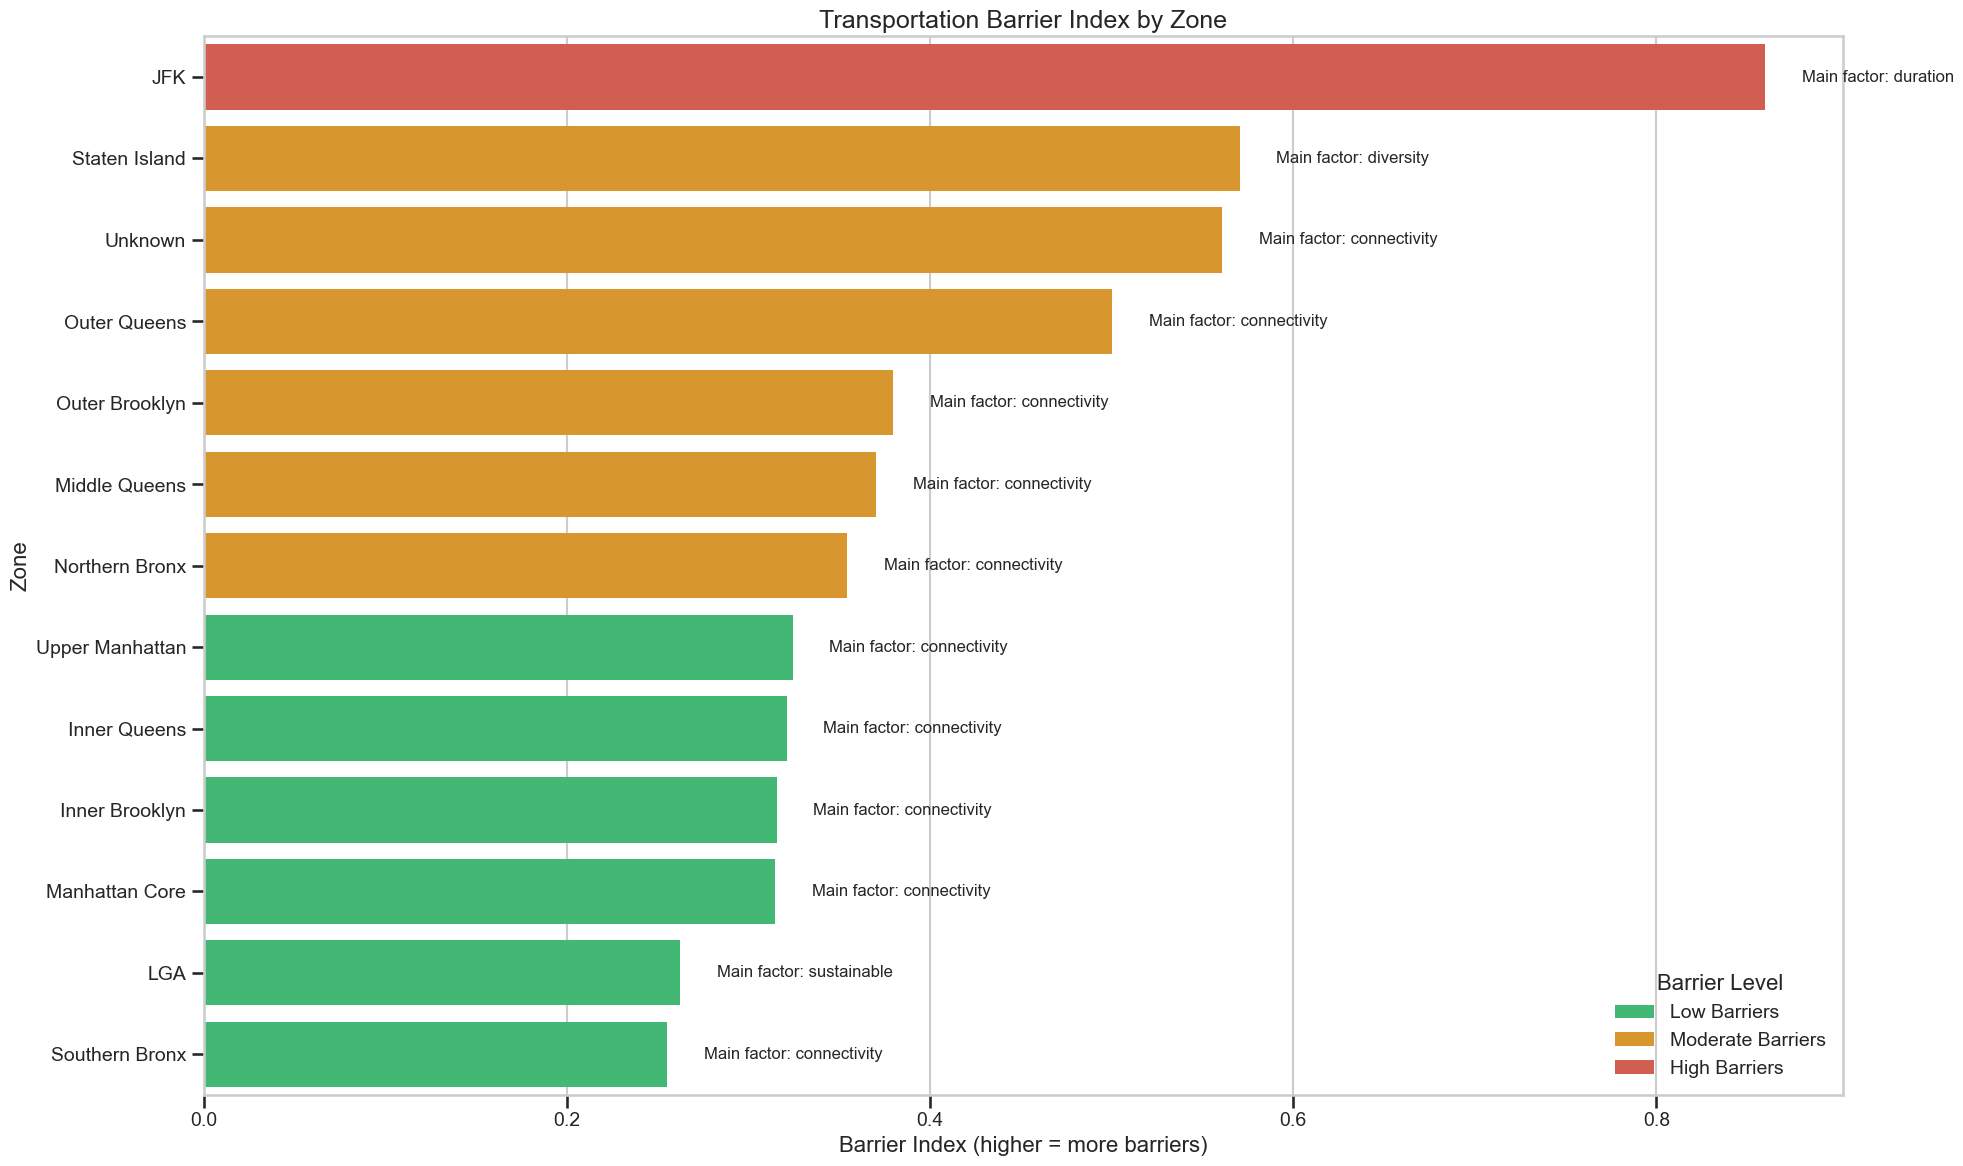

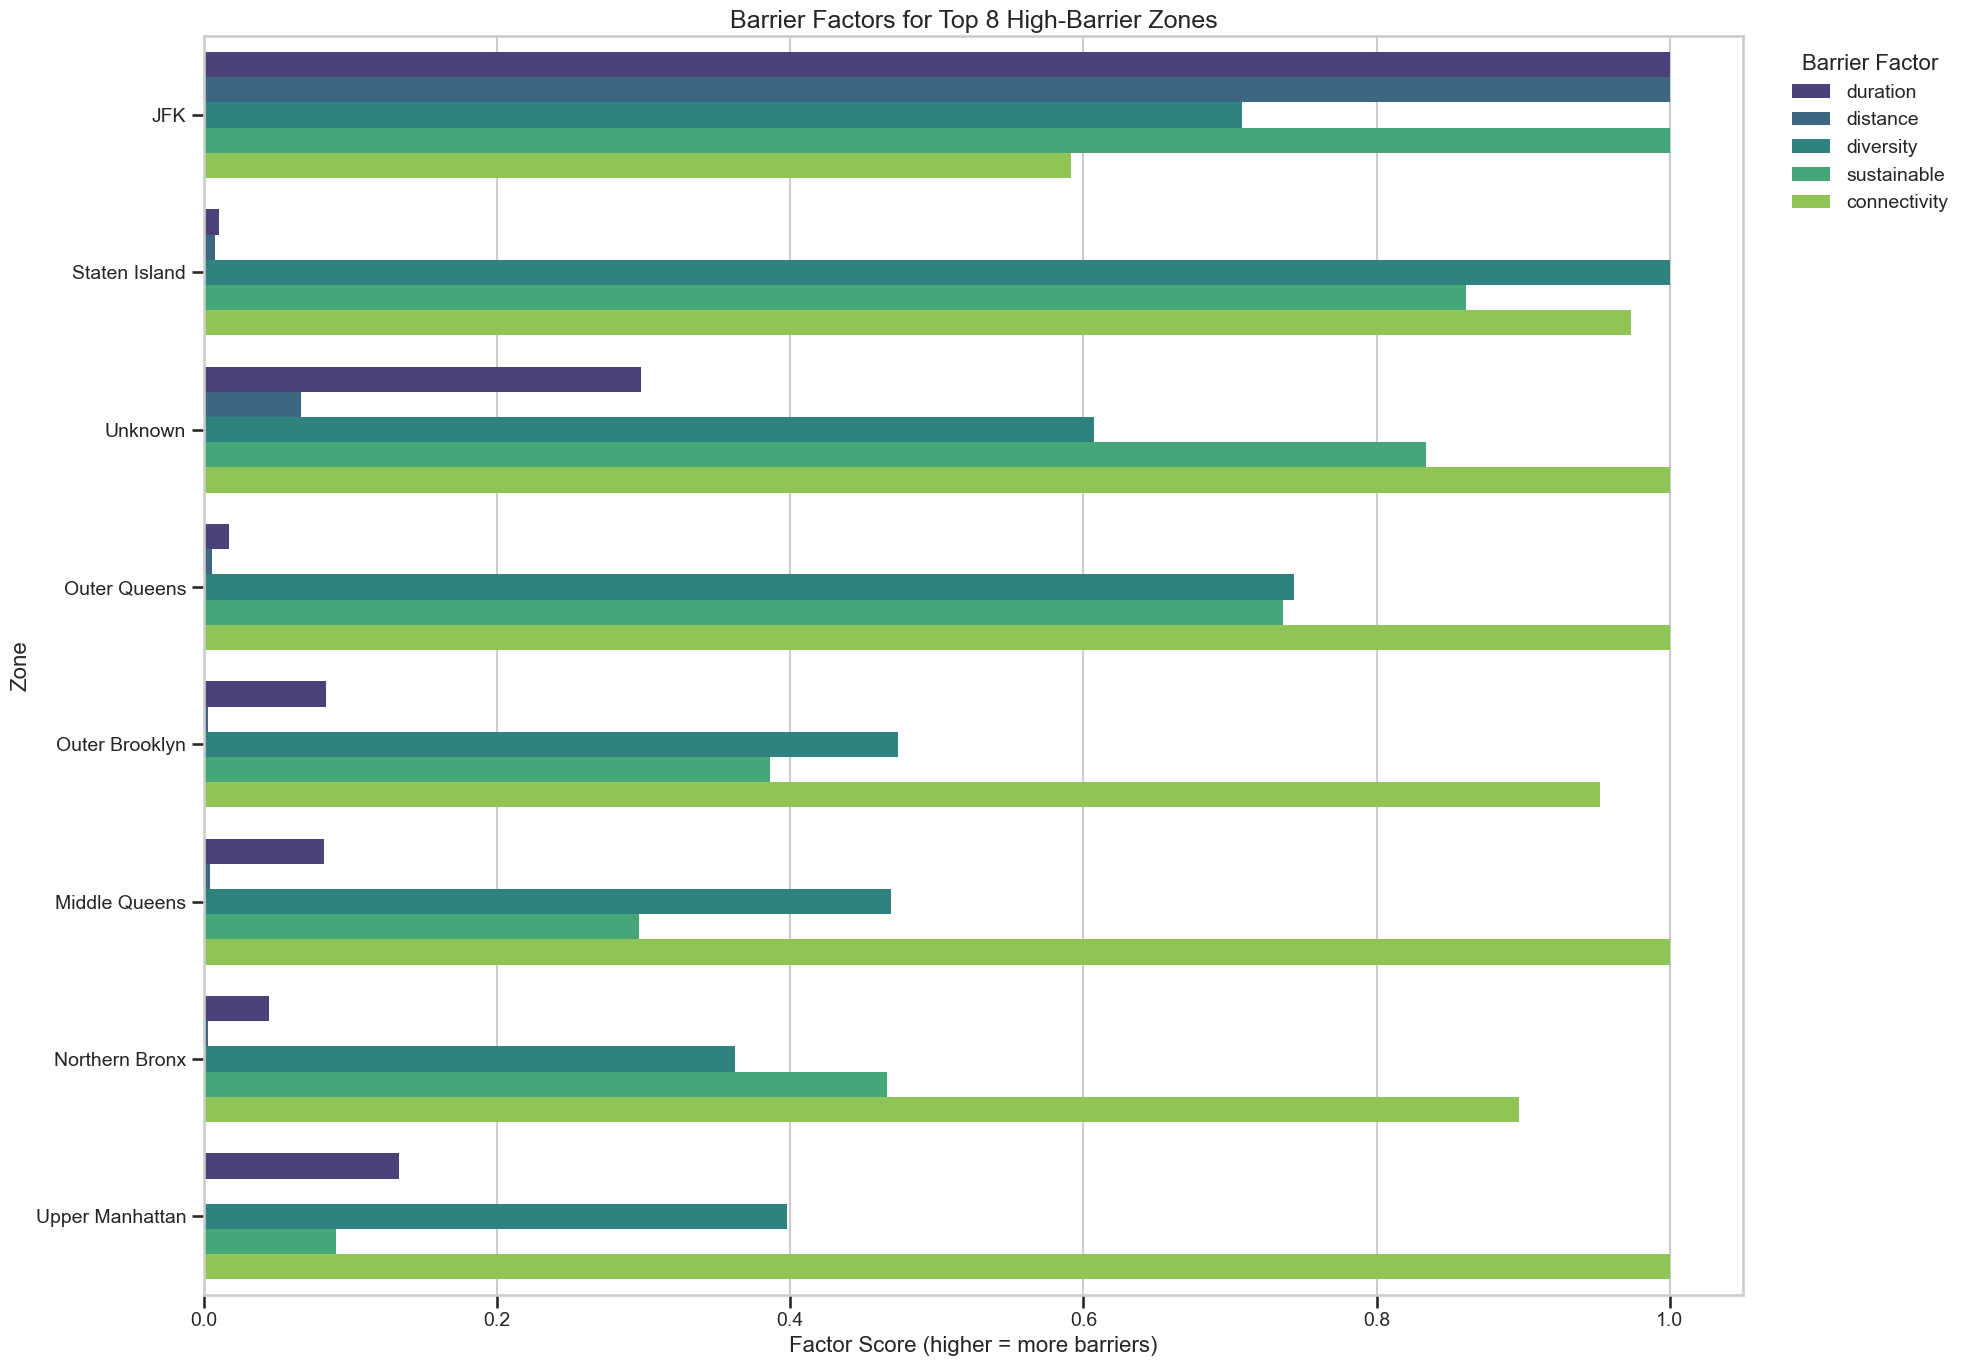

  Analysis 6.1: Transportation barrier index - Complete
  Duration DataFrame columns: ['o_cms_zone', 'mean', 'median', 'count']
  Diversity DataFrame columns: ['o_cms_zone', 'diversity_index', 'trip_count']


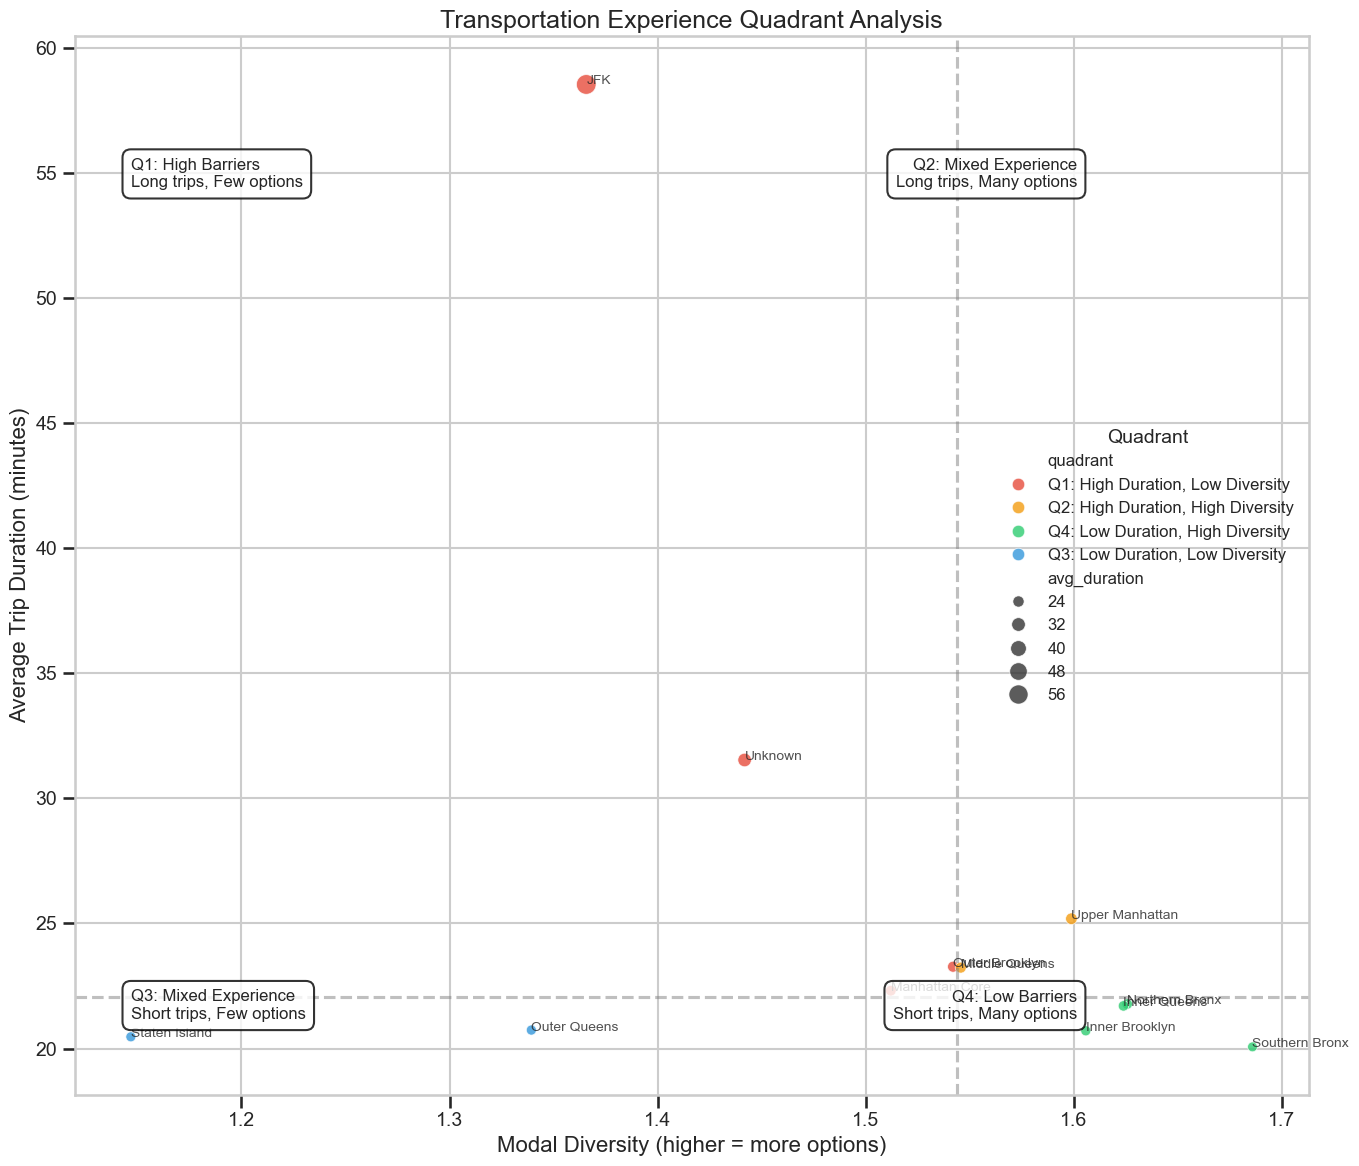

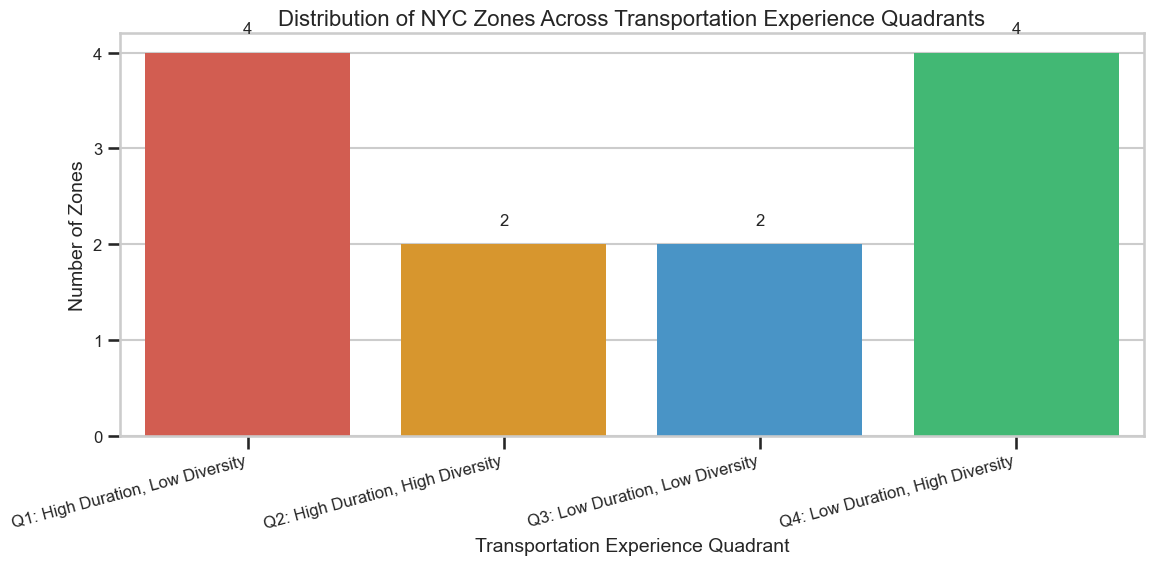

  Analysis 6.2: Quadrant analysis - Complete
  Summary file created: nyc_transit_analysis/key_findings.txt


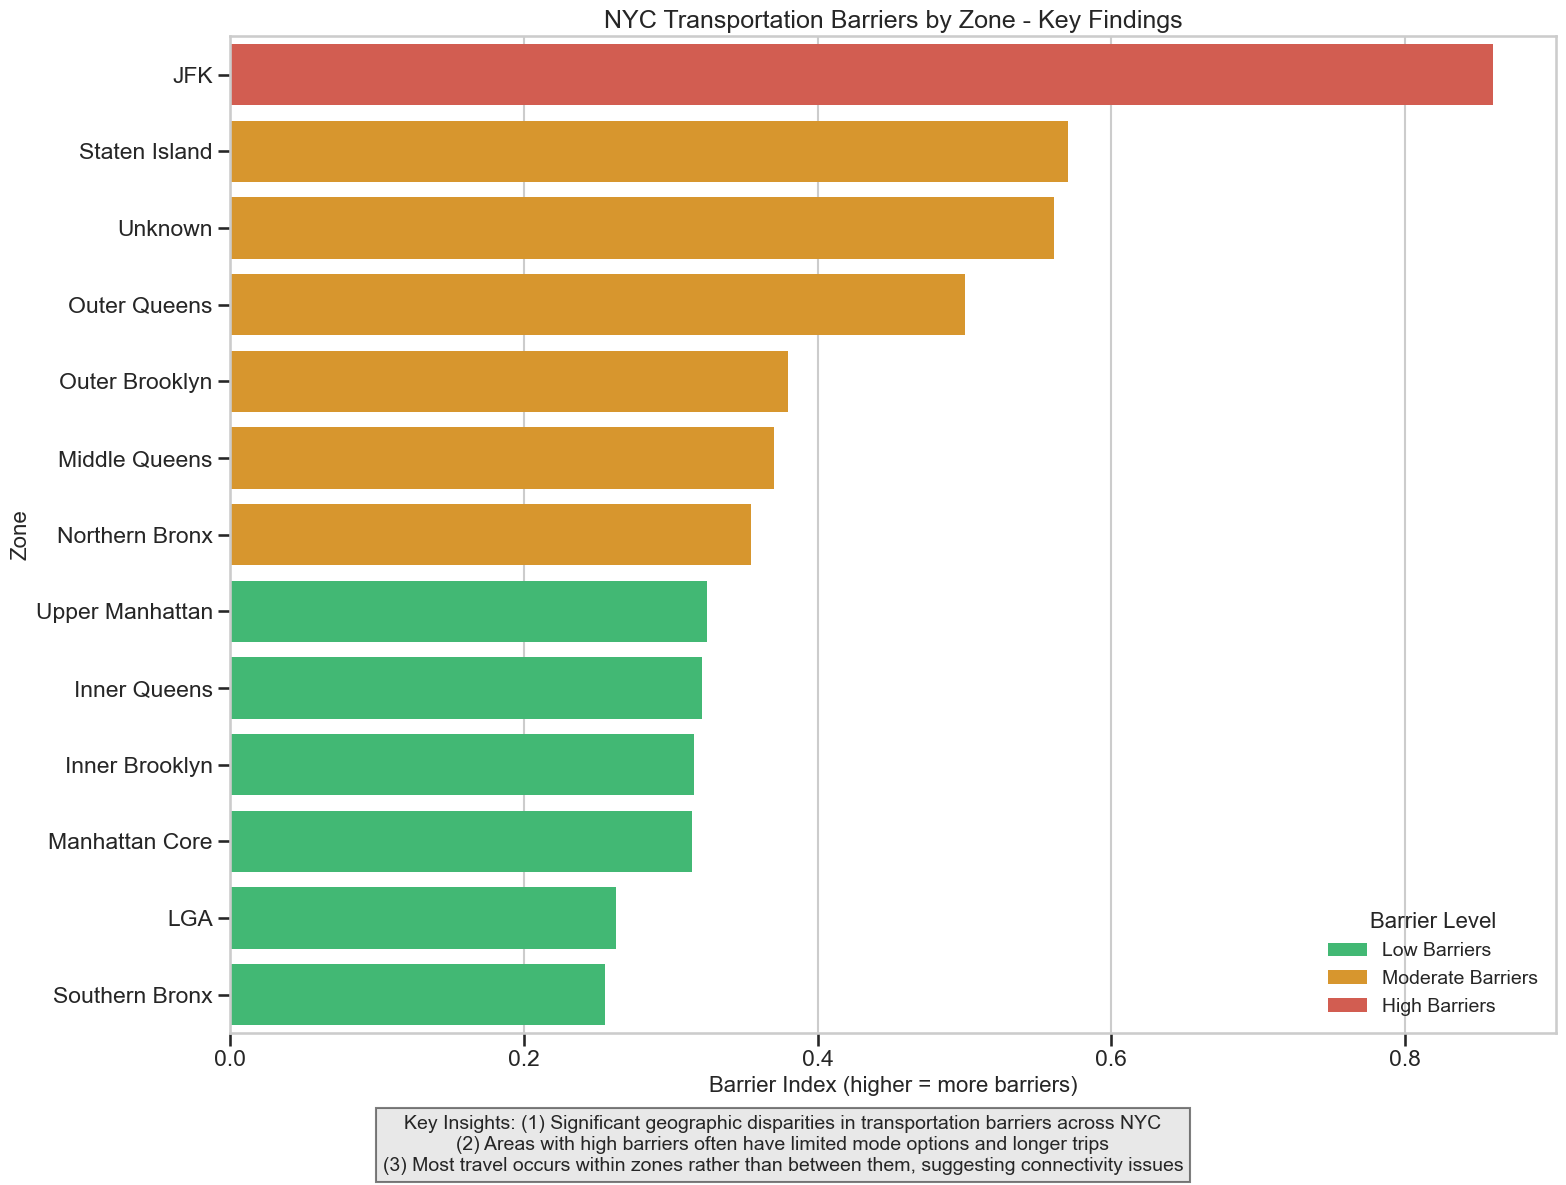

  Analysis 6.3: Summary of key findings - Complete

Analysis complete! All visualizations and findings have been saved to the 'nyc_transit_analysis' folder.
You can now use these outputs to create your visual essay on NYC transportation barriers.


In [38]:
#--------------------------------------------------------------------------
# Theme 5: Revealing Systemic Barriers - A Holistic View
#--------------------------------------------------------------------------
print("\nTheme 5: Synthesizing insights to identify systemic barriers...")

# Analysis 5.1: Transportation barrier index by zone
def calculate_barrier_index():
    # Collect relevant metrics from previous analyses
    metrics = []
    
    # Trip duration by zone (higher = more barriers)
    try:
        # Try to get trip duration data if not already calculated
        if 'trip_duration_by_zone' not in globals() or trip_duration_by_zone is None:
            clean_trips['trip_duration'] = pd.to_numeric(clean_trips['trip_duration'], errors='coerce')
            duration_by_zone = clean_trips.groupby('o_cms_zone')['trip_duration'].agg(['mean', 'count']).reset_index()
            duration_by_zone = duration_by_zone[duration_by_zone['count'] >= 100]
        else:
            duration_by_zone = trip_duration_by_zone
            
        duration_df = duration_by_zone[['o_cms_zone', 'mean']].copy()
        duration_df.columns = ['zone', 'avg_duration']
        
        # Normalize to 0-1 scale
        max_duration = duration_df['avg_duration'].max()
        min_duration = duration_df['avg_duration'].min()
        if max_duration > min_duration:  # Avoid division by zero
            duration_df['duration_score'] = (duration_df['avg_duration'] - min_duration) / (max_duration - min_duration)
            metrics.append(duration_df[['zone', 'duration_score']])
    except Exception as e:
        print(f"  Could not process trip duration for barrier index: {e}")
    
    # Trip distance by zone (higher = more barriers)
    try:
        # Try to get trip distance data if not already calculated
        if 'trip_distance_by_zone' not in globals() or trip_distance_by_zone is None:
            clean_trips['trip_distance'] = pd.to_numeric(clean_trips['trip_distance'], errors='coerce')
            distance_by_zone = clean_trips.groupby('o_cms_zone')['trip_distance'].agg(['mean', 'count']).reset_index()
            distance_by_zone = distance_by_zone[distance_by_zone['count'] >= 100]
        else:
            distance_by_zone = trip_distance_by_zone
            
        distance_df = distance_by_zone[['o_cms_zone', 'mean']].copy()
        distance_df.columns = ['zone', 'avg_distance']
        
        # Normalize to 0-1 scale
        max_distance = distance_df['avg_distance'].max()
        min_distance = distance_df['avg_distance'].min()
        if max_distance > min_distance:  # Avoid division by zero
            distance_df['distance_score'] = (distance_df['avg_distance'] - min_distance) / (max_distance - min_distance)
            metrics.append(distance_df[['zone', 'distance_score']])
    except Exception as e:
        print(f"  Could not process trip distance for barrier index: {e}")
    
    # Modal diversity (lower diversity = more barriers)
    try:
        if 'modal_diversity_results' in globals() and modal_diversity_results is not None:
            diversity_df = modal_diversity_results[['o_cms_zone', 'diversity_index']].copy()
            diversity_df.columns = ['zone', 'diversity_index']
            
            # Normalize and invert (so higher = more barriers)
            max_diversity = diversity_df['diversity_index'].max()
            min_diversity = diversity_df['diversity_index'].min()
            if max_diversity > min_diversity:  # Avoid division by zero
                diversity_df['diversity_score'] = 1 - (diversity_df['diversity_index'] - min_diversity) / (max_diversity - min_diversity)
                metrics.append(diversity_df[['zone', 'diversity_score']])
    except Exception as e:
        print(f"  Could not process modal diversity for barrier index: {e}")
    
    # Sustainable transportation (lower % = more barriers)
    try:
        if 'sustainable_transport_results' in globals() and sustainable_transport_results is not None:
            sustainable_df = sustainable_transport_results.copy()
            sustainable_df.columns = ['zone', 'sustainable_pct']
            
            # Normalize and invert
            max_sust = sustainable_df['sustainable_pct'].max()
            min_sust = sustainable_df['sustainable_pct'].min()
            if max_sust > min_sust:  # Avoid division by zero
                sustainable_df['sustainable_score'] = 1 - (sustainable_df['sustainable_pct'] - min_sust) / (max_sust - min_sust)
                metrics.append(sustainable_df[['zone', 'sustainable_score']])
    except Exception as e:
        print(f"  Could not process sustainable transportation for barrier index: {e}")
    
    # Network connectivity (lower connectivity = more barriers)
    try:
        if 'network_metrics' in globals() and network_metrics is not None:
            connect_df = network_metrics[['zone', 'connectivity_score']].copy()
            
            # Normalize and invert (so higher = more barriers)
            max_connect = connect_df['connectivity_score'].max()
            min_connect = connect_df['connectivity_score'].min()
            if max_connect > min_connect:  # Avoid division by zero
                connect_df['connectivity_barrier_score'] = 1 - (connect_df['connectivity_score'] - min_connect) / (max_connect - min_connect)
                metrics.append(connect_df[['zone', 'connectivity_barrier_score']])
    except Exception as e:
        print(f"  Could not process network connectivity for barrier index: {e}")
    
    # Merge all metrics
    if not metrics:
        print("  Not enough metrics available to calculate barrier index")
        return None
    
    barrier_index = metrics[0]
    for df in metrics[1:]:
        barrier_index = pd.merge(barrier_index, df, on='zone', how='outer')
    
    # Calculate combined index (average of available scores)
    score_columns = [col for col in barrier_index.columns if col.endswith('_score')]
    print(f"  Combining {len(score_columns)} metrics: {score_columns}")
    
    # For each zone, calculate the average of all available scores (handle missing values)
    barrier_index['barrier_index'] = barrier_index[score_columns].mean(axis=1)
    
    # Sort by barrier index
    barrier_index = barrier_index.sort_values('barrier_index', ascending=False)
    
    # Create barrier categories
    barrier_index['barrier_category'] = pd.cut(
        barrier_index['barrier_index'],
        bins=[0, 0.33, 0.66, 1],
        labels=['Low Barriers', 'Moderate Barriers', 'High Barriers']
    )
    
    # HORIZONTAL BAR CHART for barrier index
    plt.figure(figsize=(20, 12))
    ax = sns.barplot(
        y='zone', 
        x='barrier_index', 
        hue='barrier_category',
        dodge=False,
        data=barrier_index,
        palette={'Low Barriers': '#2ecc71', 'Moderate Barriers': '#f39c12', 'High Barriers': '#e74c3c'}
    )
    plt.title('Transportation Barrier Index by Zone', fontsize=18)
    plt.ylabel('Zone', fontsize=16)
    plt.xlabel('Barrier Index (higher = more barriers)', fontsize=16)
    
    # Add annotations explaining what contributes to each zone's score
    for i, row in enumerate(barrier_index.itertuples()):
        # Find the highest contributor to this zone's barrier score
        max_score_col = None
        max_score_val = -1
        for col in score_columns:
            if pd.notna(getattr(row, col)) and getattr(row, col) > max_score_val:
                max_score_val = getattr(row, col)
                max_score_col = col
        
        if max_score_col:
            # Extract the factor name from the column name (remove _score suffix)
            factor = max_score_col.replace('_score', '').replace('_barrier', '')
            plt.text(row.barrier_index + 0.02, i, f"Main factor: {factor}", va='center', fontsize=12)
    
    # Increase font sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.legend(title='Barrier Level', fontsize=14, title_fontsize=16)
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/6_1_barrier_index.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display visualization in notebook
    
    # Create a breakdown of contributing factors for top barrier zones
    top_barrier_zones = barrier_index.head(8)
    
    # Melt the dataframe to get factors in one column for plotting
    plot_data = pd.melt(
        top_barrier_zones, 
        id_vars=['zone', 'barrier_index', 'barrier_category'],
        value_vars=score_columns,
        var_name='factor',
        value_name='score'
    )
    
    # Clean up factor names
    plot_data['factor'] = plot_data['factor'].str.replace('_score', '').str.replace('_barrier', '')
    
    # HORIZONTAL BAR CHART for factor breakdown
    plt.figure(figsize=(20, 14))
    ax = sns.barplot(
        y='zone',
        x='score',
        hue='factor',
        data=plot_data.dropna(),
        palette='viridis'
    )
    plt.title('Barrier Factors for Top 8 High-Barrier Zones', fontsize=18)
    plt.ylabel('Zone', fontsize=16)
    plt.xlabel('Factor Score (higher = more barriers)', fontsize=16)
    
    # Increase font sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.legend(title='Barrier Factor', fontsize=14, title_fontsize=16, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/6_1b_barrier_factors.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display visualization in notebook
    
    print("  Analysis 6.1: Transportation barrier index - Complete")
    return barrier_index

# Analysis 6.2: Quadrant analysis of trip duration vs. modal options
def quadrant_analysis():
    # Check if we have the necessary data
    has_duration = False
    has_diversity = False
    
    # Try to get trip duration data if not already calculated
    if 'trip_duration_by_zone' in globals() and trip_duration_by_zone is not None:
        duration_df = trip_duration_by_zone.copy()
        has_duration = True
    else:
        try:
            clean_trips['trip_duration'] = pd.to_numeric(clean_trips['trip_duration'], errors='coerce')
            duration_df = clean_trips.groupby('o_cms_zone')['trip_duration'].agg(['mean', 'count']).reset_index()
            duration_df = duration_df[duration_df['count'] >= 100]
            has_duration = True
        except Exception as e:
            print(f"  Could not process trip duration for quadrant analysis: {e}")
    
    # Try to get modal diversity data
    if 'modal_diversity_results' in globals() and modal_diversity_results is not None:
        diversity_df = modal_diversity_results.copy()
        has_diversity = True
    else:
        try:
            # Try to calculate modal diversity
            if 'mode_category' in clean_trips.columns:
                def shannon_diversity(x):
                    proportions = x.value_counts(normalize=True)
                    return -sum(proportions * np.log(proportions))
                
                diversity_df = clean_trips.groupby('o_cms_zone')['mode_category'].apply(shannon_diversity).reset_index()
                diversity_df.columns = ['o_cms_zone', 'diversity_index']
                
                # Add count of trips for reference
                zone_counts = clean_trips.groupby('o_cms_zone').size().reset_index(name='trip_count')
                diversity_df = diversity_df.merge(zone_counts, on='o_cms_zone')
                diversity_df = diversity_df[diversity_df['trip_count'] >= 100]
                
                has_diversity = True
        except Exception as e:
            print(f"  Could not calculate modal diversity for quadrant analysis: {e}")
    
    if not has_duration or not has_diversity:
        print("  Required data for quadrant analysis not available")
        return None
    
    # Prepare data for quadrant analysis
    # First, print column information to diagnose the issue
    print(f"  Duration DataFrame columns: {duration_df.columns.tolist()}")
    print(f"  Diversity DataFrame columns: {diversity_df.columns.tolist()}")
    
    # Extract only the columns we need, avoiding column renaming issues
    zone_column = 'o_cms_zone' if 'o_cms_zone' in duration_df.columns else 'zone'
    duration_column = 'mean' if 'mean' in duration_df.columns else 'avg_duration'
    
    # Create a clean DataFrame with just what we need
    duration_clean = pd.DataFrame({
        'zone': duration_df[zone_column],
        'avg_duration': duration_df[duration_column]
    })
    
    zone_column = 'o_cms_zone' if 'o_cms_zone' in diversity_df.columns else 'zone'
    diversity_column = 'diversity_index' if 'diversity_index' in diversity_df.columns else 'diversity_index'
    
    # Create a clean DataFrame with just what we need
    diversity_clean = pd.DataFrame({
        'zone': diversity_df[zone_column],
        'diversity_index': diversity_df[diversity_column]
    })
    
    # Merge data using the clean DataFrames
    quadrant_df = pd.merge(duration_clean, diversity_clean, on='zone', how='inner')
    
    # Calculate quadrant boundaries (median values)
    duration_median = quadrant_df['avg_duration'].median()
    diversity_median = quadrant_df['diversity_index'].median()
    
    # Assign quadrants
    quadrant_df['duration_high'] = quadrant_df['avg_duration'] > duration_median
    quadrant_df['diversity_high'] = quadrant_df['diversity_index'] > diversity_median
    
    quadrant_df['quadrant'] = 'Q3: Low Duration, Low Diversity'  # Default
    quadrant_df.loc[(quadrant_df['duration_high']) & (quadrant_df['diversity_high']), 'quadrant'] = 'Q2: High Duration, High Diversity'
    quadrant_df.loc[(quadrant_df['duration_high']) & (~quadrant_df['diversity_high']), 'quadrant'] = 'Q1: High Duration, Low Diversity'
    quadrant_df.loc[(~quadrant_df['duration_high']) & (quadrant_df['diversity_high']), 'quadrant'] = 'Q4: Low Duration, High Diversity'
    
    # Create a custom color map for quadrants
    quadrant_colors = {
        'Q1: High Duration, Low Diversity': '#e74c3c',  # Red - worst case
        'Q2: High Duration, High Diversity': '#f39c12',  # Orange - mixed
        'Q3: Low Duration, Low Diversity': '#3498db',  # Blue - mixed
        'Q4: Low Duration, High Diversity': '#2ecc71'   # Green - best case
    }
    
    # Visualize quadrants
    plt.figure(figsize=(14, 12))
    scatter = sns.scatterplot(
        x='diversity_index', 
        y='avg_duration', 
        hue='quadrant',
        size='avg_duration',
        sizes=(50, 200),
        data=quadrant_df,
        palette=quadrant_colors,
        alpha=0.8
    )
    
    # Add zone labels
    for i, row in quadrant_df.iterrows():
        plt.annotate(row['zone'], (row['diversity_index'], row['avg_duration']), 
                   fontsize=10, alpha=0.8)
    
    # Add quadrant lines
    plt.axvline(x=diversity_median, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(y=duration_median, color='gray', linestyle='--', alpha=0.5)
    
    # Add quadrant annotations
    plt.text(quadrant_df['diversity_index'].min(), quadrant_df['avg_duration'].max() * 0.95, 
           "Q1: High Barriers\nLong trips, Few options", 
           fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.text(quadrant_df['diversity_index'].max() * 0.95, quadrant_df['avg_duration'].max() * 0.95, 
           "Q2: Mixed Experience\nLong trips, Many options", 
           fontsize=12, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.text(quadrant_df['diversity_index'].min(), quadrant_df['avg_duration'].min() * 1.05, 
           "Q3: Mixed Experience\nShort trips, Few options", 
           fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.text(quadrant_df['diversity_index'].max() * 0.95, quadrant_df['avg_duration'].min() * 1.05, 
           "Q4: Low Barriers\nShort trips, Many options", 
           fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.title('Transportation Experience Quadrant Analysis', fontsize=18)
    plt.xlabel('Modal Diversity (higher = more options)', fontsize=16)
    plt.ylabel('Average Trip Duration (minutes)', fontsize=16)
    
    # Increase font sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.legend(title='Quadrant', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/6_2_quadrant_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display visualization in notebook
    
    # Count zones in each quadrant
    quadrant_counts = quadrant_df['quadrant'].value_counts().reset_index()
    quadrant_counts.columns = ['quadrant', 'count']
    
    # Order quadrants
    quadrant_order = ['Q1: High Duration, Low Diversity', 'Q2: High Duration, High Diversity', 
                    'Q3: Low Duration, Low Diversity', 'Q4: Low Duration, High Diversity']
    quadrant_counts['quadrant'] = pd.Categorical(
        quadrant_counts['quadrant'], 
        categories=quadrant_order,
        ordered=True
    )
    quadrant_counts = quadrant_counts.sort_values('quadrant')
    
    # Create a bar chart of quadrant distribution
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='quadrant', 
        y='count', 
        data=quadrant_counts,
        palette=[quadrant_colors[q] for q in quadrant_order]
    )
    plt.title('Distribution of NYC Zones Across Transportation Experience Quadrants', fontsize=16)
    plt.xlabel('Transportation Experience Quadrant', fontsize=14)
    plt.ylabel('Number of Zones', fontsize=14)
    
    # Add count annotations
    for i, row in enumerate(quadrant_counts.itertuples()):
        plt.text(i, row.count + 0.2, f"{row.count}", ha='center', fontsize=12)
    
    # Increase font sizes and rotate x labels
    plt.xticks(fontsize=12, rotation=15, ha='right')
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('nyc_transit_analysis/6_2b_quadrant_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display visualization in notebook
    
    print("  Analysis 6.2: Quadrant analysis - Complete")
    return quadrant_df

# Analysis 6.3: Summary of key findings
def summarize_findings():
    # Create a text summary file
    summary_file = 'nyc_transit_analysis/key_findings.txt'
    
    with open(summary_file, 'w') as f:
        f.write("NYC TRANSPORTATION BARRIERS: KEY FINDINGS\n")
        f.write("========================================\n\n")
        
        f.write("1. SPATIAL PATTERNS IN NYC TRANSPORTATION\n")
        f.write("----------------------------------------\n\n")
        
        # Try to include findings about trip duration
        try:
            if 'trip_duration_by_zone' in globals() and trip_duration_by_zone is not None:
                top_duration = trip_duration_by_zone.head(3)
                f.write(f"- Longest average trip durations were found in: {', '.join(top_duration['o_cms_zone'])}\n")
                f.write(f"  with durations ranging from {top_duration['mean'].min():.1f} to {top_duration['mean'].max():.1f} minutes.\n\n")
        except Exception:
            pass
        
        # Try to include findings about trip distance
        try:
            if 'trip_distance_by_zone' in globals() and trip_distance_by_zone is not None:
                top_distance = trip_distance_by_zone.head(3)
                f.write(f"- Longest average trip distances were found in: {', '.join(top_distance['o_cms_zone'])}\n")
                f.write(f"  with distances ranging from {top_distance['mean'].min():.1f} to {top_distance['mean'].max():.1f} miles.\n\n")
        except Exception:
            pass
        
        # Try to include findings about travel speed
        try:
            if 'zone_speeds' in globals() and zone_speeds is not None:
                slowest_zones = zone_speeds.sort_values('mean').head(3)
                f.write(f"- Slowest transportation speeds were found in: {', '.join(slowest_zones['o_cms_zone'])}\n")
                f.write(f"  with average speeds ranging from {slowest_zones['mean'].min():.1f} to {slowest_zones['mean'].max():.1f} mph.\n\n")
        except Exception:
            pass
        
        f.write("2. CONNECTIVITY PATTERNS\n")
        f.write("----------------------\n\n")
        
        # Try to include findings about OD flows
        try:
            if 'od_flows' in globals() and od_flows is not None:
                top_flows = od_flows.head(5)
                f.write("- Top 5 origin-destination pairs:\n")
                for _, row in top_flows.iterrows():
                    f.write(f"  * {row['o_cms_zone']} → {row['d_cms_zone']}: {row['trip_count']} trips\n")
                f.write("\n")
        except Exception:
            pass
        
        # Try to include findings about network connectivity
        try:
            if 'network_metrics' in globals() and network_metrics is not None:
                top_connected = network_metrics.head(3)
                least_connected = network_metrics.tail(3)
                
                f.write(f"- Most connected zones: {', '.join(top_connected['zone'])}\n")
                f.write(f"- Least connected zones: {', '.join(least_connected['zone'])}\n\n")
        except Exception:
            pass
        
        # Try to include findings about borough-level flows
        try:
            if 'borough_flows' in globals() and borough_flows is not None:
                f.write("- Significant inter-borough travel barriers identified;\n")
                f.write("  most trips remain within the same borough rather than crossing borough boundaries.\n\n")
        except Exception:
            pass
        
        f.write("3. TRANSPORTATION MODE PATTERNS\n")
        f.write("-----------------------------\n\n")
        
        # Try to include findings about mode choice
        try:
            if 'mode_by_zone_results' in globals() and mode_by_zone_results is not None:
                f.write("- Mode choice varies significantly by neighborhood, reflecting\n")
                f.write("  disparities in transportation options across different zones.\n\n")
        except Exception:
            pass
        
        # Try to include findings about modal diversity
        try:
            if 'modal_diversity_results' in globals() and modal_diversity_results is not None:
                most_diverse = modal_diversity_results.head(3)
                least_diverse = modal_diversity_results.tail(3)
                
                f.write(f"- Zones with highest modal diversity: {', '.join(most_diverse['o_cms_zone'])}\n")
                f.write(f"- Zones with lowest modal diversity: {', '.join(least_diverse['o_cms_zone'])}\n\n")
        except Exception:
            pass
        
        # Try to include findings about sustainable transportation
        try:
            if 'sustainable_transport_results' in globals() and sustainable_transport_results is not None:
                most_sustainable = sustainable_transport_results.head(3)
                least_sustainable = sustainable_transport_results.tail(3)
                
                f.write(f"- Zones with highest sustainable transportation adoption: {', '.join(most_sustainable['o_cms_zone'])}\n")
                f.write(f"- Zones with lowest sustainable transportation adoption: {', '.join(least_sustainable['o_cms_zone'])}\n\n")
        except Exception:
            pass
        
        f.write("4. MULTI-MODAL INTEGRATION\n")
        f.write("------------------------\n\n")
        
        # Try to include findings about multi-modal trips
        try:
            if 'multimodal_results' in globals() and multimodal_results is not None and isinstance(multimodal_results, tuple):
                multimodal_by_zone = multimodal_results[0]
                highest_multimodal = multimodal_by_zone.head(3)
                
                f.write(f"- Zones with highest percentage of multi-modal trips: {', '.join(highest_multimodal['o_cms_zone'])}\n")
                f.write(f"  with percentages ranging from {highest_multimodal['multimodal_percentage'].min():.1f}% to {highest_multimodal['multimodal_percentage'].max():.1f}%\n\n")
                
                # Try to include findings about mode combinations
                if len(multimodal_results) > 1:
                    mode_combinations = multimodal_results[1]
                    top_combination = mode_combinations.iloc[0]
                    
                    f.write(f"- The most common multi-modal combination is '{top_combination['combination']}',\n")
                    f.write(f"  occurring in {top_combination['count']} trips.\n\n")
        except Exception:
            pass
        
        f.write("5. TRIP PURPOSE AND TIMING\n")
        f.write("------------------------\n\n")
        
        # Try to include findings about trip purposes
        try:
            if 'purpose_results' in globals() and purpose_results is not None and isinstance(purpose_results, tuple):
                purpose_counts = purpose_results[0]
                top_purposes = purpose_counts.head(3)
                
                f.write("- Top 3 trip purposes:\n")
                for _, row in top_purposes.iterrows():
                    f.write(f"  * {row['purpose']}: {row['percentage']:.1f}% of all trips\n")
                f.write("\n")
        except Exception:
            pass
        
        # Try to include findings about time patterns
        try:
            if 'time_results' in globals() and time_results is not None:
                f.write("- Trip timing analysis revealed limited time-of-day variability in the dataset,\n")
                f.write("  with most trips recorded at hour 0, suggesting a data limitation.\n\n")
        except Exception:
            pass
        
        f.write("6. SYSTEMIC BARRIERS\n")
        f.write("------------------\n\n")
        
        # Try to include findings about barrier index
        try:
            if 'barrier_index' in globals() and barrier_index is not None:
                high_barrier_zones = barrier_index.head(5)
                
                f.write("- Zones with highest transportation barriers:\n")
                for _, row in high_barrier_zones.iterrows():
                    f.write(f"  * {row['zone']}: Barrier Index {row['barrier_index']:.2f}\n")
                f.write("\n")
        except Exception:
            pass
        
        # Try to include findings about quadrant analysis
        try:
            if 'quadrant_df' in globals() and quadrant_df is not None:
                high_barrier_quadrant = quadrant_df[quadrant_df['quadrant'] == 'Q1: High Duration, Low Diversity']
                
                f.write("- Areas facing both long trip durations and limited transportation options:\n")
                for _, row in high_barrier_quadrant.iterrows():
                    f.write(f"  * {row['zone']}: {row['avg_duration']:.1f} min avg. duration, {row['diversity_index']:.2f} modal diversity\n")
                f.write("\n")
        except Exception:
            pass
        
        # Recommendations section
        f.write("7. POTENTIAL INTERVENTIONS\n")
        f.write("------------------------\n\n")
        
        f.write("Based on the analysis, the following interventions could address transportation barriers:\n\n")
        
        # Try to include zone-specific recommendations
        try:
            if 'barrier_index' in globals() and barrier_index is not None:
                high_barrier_zones = barrier_index.head(3)['zone'].tolist()
                f.write(f"- Targeted transit improvements in high-barrier zones ({', '.join(high_barrier_zones)})\n")
        except Exception:
            pass
        
        # General recommendations
        f.write("- Improve multi-modal integration at key transfer points\n")
        f.write("- Enhance transit service during peak hours to reduce congestion-related delays\n")
        f.write("- Increase transportation options in areas with low modal diversity\n")
        f.write("- Address geographic disparities in transportation access across NYC zones\n")
        f.write("- Develop targeted strategies for improving connectivity between boroughs\n\n")
        
        f.write("8. LIMITATIONS OF THIS ANALYSIS\n")
        f.write("-----------------------------\n\n")
        
        f.write("- Limited temporal data (primarily hour 0) restricted time-of-day analysis\n")
        f.write("- Demographic-level analysis was not possible without linking to person-level data\n")
        f.write("- Geographic analysis is limited to CMS zones rather than more granular neighborhood levels\n")
        f.write("- The barrier index is a simplified measure and should be interpreted with caution\n")
    
    print(f"  Summary file created: {summary_file}")
    
    # Create a visualization that compiles key insights
    try:
        # Use the barrier index as the basis if available
        if 'barrier_index' in globals() and barrier_index is not None:
            plt.figure(figsize=(16, 12))
            
            # Create a modified barrier index with categories
            barrier_viz = barrier_index.copy()
            
            # Create visualization
            ax = sns.barplot(
                y='zone', 
                x='barrier_index', 
                hue='barrier_category',
                dodge=False,
                data=barrier_viz,
                palette={'Low Barriers': '#2ecc71', 'Moderate Barriers': '#f39c12', 'High Barriers': '#e74c3c'}
            )
            
            plt.title('NYC Transportation Barriers by Zone - Key Findings', fontsize=18)
            plt.xlabel('Barrier Index (higher = more barriers)', fontsize=16)
            plt.ylabel('Zone', fontsize=16)
            
            # Annotate with insights
            plt.figtext(0.5, 0.01, 
                      "Key Insights: (1) Significant geographic disparities in transportation barriers across NYC\n" +
                      "(2) Areas with high barriers often have limited mode options and longer trips\n" +
                      "(3) Most travel occurs within zones rather than between them, suggesting connectivity issues",
                      ha="center", fontsize=14, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})
            
            plt.legend(title='Barrier Level', fontsize=14, title_fontsize=16)
            plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust for the text at bottom
            plt.savefig('nyc_transit_analysis/6_3_barrier_summary.png', dpi=300, bbox_inches='tight')
            plt.show()
    except Exception as e:
        print(f"  Could not create summary visualization: {e}")
    
    print("  Analysis 6.3: Summary of key findings - Complete")

# Run Theme 6 analyses
barrier_index = calculate_barrier_index()
quadrant_df = quadrant_analysis()
summarize_findings()

print("\nAnalysis complete! All visualizations and findings have been saved to the 'nyc_transit_analysis' folder.")
print("You can now use these outputs to create your visual essay on NYC transportation barriers.")